# **CIS5300 Final Project:** *From Bart to Edge - Education*

## **1. Load and Preprocess (Must Run!)**

### **1.1 Download Libraries**

In [ ]:
!pip install datasets optimum auto-gptq sentencepiece bitsandbytes sacremoses sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.1/424.1 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.5/23.5 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **1.2 Import Libraries**

In [ ]:
import zipfile
import os
import pandas as pd
from datasets import Dataset
import random
import torch
from torch.ao.quantization import (
    prepare_qat,
    convert,
    QConfig,
    default_observer,
    default_per_channel_weight_observer,
    get_default_qat_qconfig,
    default_weight_observer
)

from transformers import MBart50Tokenizer, MBartForConditionalGeneration, M2M100Tokenizer, M2M100ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer, TrainerCallback, AutoModelForCausalLM, AutoTokenizer, pipeline, AutoTokenizer, AutoModelForSeq2SeqLM, BitsAndBytesConfig
from peft import get_peft_model, LoraConfig, TaskType
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding, GenerationConfig
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm import tqdm
import copy
from torch.utils.data import DataLoader
import itertools
from itertools import product
import psutil
import time
import matplotlib.pyplot as plt
import threading
import gc

### **1.3 Download and Initialize Models**

#### **1.3.1 mBart**

In [ ]:
# Model names
mbart_model_name = "facebook/mbart-large-50-many-to-many-mmt"

# Source and target languages
SRC_LANG = "zh_CN"
TGT_LANG = "en_XX"

# Initialize mBART model and tokenizer
tokenizer_mbart = MBart50Tokenizer.from_pretrained(mbart_model_name)
model_mbart = MBartForConditionalGeneration.from_pretrained(mbart_model_name)
tokenizer_mbart.src_lang = SRC_LANG
tokenizer_mbart.tgt_lang = TGT_LANG

# Ensure all parameters in the original model are trainable
for param in model_mbart.parameters():
    param.requires_grad = True


# LoRA configuration for mBART
mbart_lora_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    inference_mode=False,
    r=8,  # Low-rank dimension
    lora_alpha=64,
    lora_dropout=0.0,
    target_modules=["q_proj", "v_proj"],
)

# Apply LoRA to mBART model
model_mbart_lora = copy.deepcopy(model_mbart)
model_mbart_lora = get_peft_model(model_mbart_lora, mbart_lora_config)

# Verify that only LoRA-specific layers are trainable
for name, param in model_mbart_lora.named_parameters():
    if any(layer in name for layer in mbart_lora_config.target_modules):
        param.requires_grad = True  # LoRA layers should be trainable
    else:
        param.requires_grad = False  # Non-LoRA layers should be frozen


# mBart with Layer Freezing
model_mbart_freeze = copy.deepcopy(model_mbart)

# Layer Freezing Configuration
freeze_encoder_layers = 8  # Number of encoder layers to freeze
freeze_decoder_layers = 8  # Number of decoder layers to freeze

# Apply Layer Freezing to the base mBART model
for name, param in model_mbart_freeze.named_parameters():
    # Freeze encoder layers
    if "encoder.layers" in name:
        layer_num = int(name.split(".")[3])  # Extract layer index
        if layer_num < freeze_encoder_layers:
            param.requires_grad = False  # Freeze parameters
    # Freeze decoder layers
    elif "decoder.layers" in name:
        layer_num = int(name.split(".")[3])  # Extract layer index
        if layer_num < freeze_decoder_layers:
            param.requires_grad = False  # Freeze parameters
    else:
        param.requires_grad = True  # Keep other parameters trainable


print("mBart and tokenizers initialized successfully.")

tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

mBart and tokenizers initialized successfully.


In [ ]:
def print_model_parameters(model, model_name="Model"):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Print summaries
    print(f"{model_name} - Total Parameters: {total_params}")
    print(f"{model_name} - Trainable Parameters (All): {trainable_params}")
    print(f"{model_name} - Percentage of Parameters to Fine-tune (All): {100 * trainable_params / total_params:.2f}%\n")

In [ ]:
# Display parameter summaries for the original and LoRA-enhanced models
print_model_parameters(model_mbart, "mBART (original)")
print_model_parameters(model_mbart_lora, "mBART (LoRA)")
print_model_parameters(model_mbart_freeze, "mBART (Layer Freezing)")

mBART (original) - Total Parameters: 610879488
mBART (original) - Trainable Parameters (All): 610879488
mBART (original) - Percentage of Parameters to Fine-tune (All): 100.00%

mBART (LoRA) - Total Parameters: 612059136
mBART (LoRA) - Trainable Parameters (All): 76750848
mBART (LoRA) - Percentage of Parameters to Fine-tune (All): 12.54%

mBART (Layer Freezing) - Total Parameters: 610879488
mBART (Layer Freezing) - Trainable Parameters (All): 375736320
mBART (Layer Freezing) - Percentage of Parameters to Fine-tune (All): 61.51%



#### **1.3.2 M2M100**

In [ ]:
# Model names
mtm_model_name = "facebook/m2m100_418M"

# Initialize M2M100 model and tokenizer
tokenizer_mtm = M2M100Tokenizer.from_pretrained(mtm_model_name)
model_mtm = M2M100ForConditionalGeneration.from_pretrained(mtm_model_name)

# Create a deep copy of the original model for LoRA
model_mtm_lora = copy.deepcopy(model_mtm)

# LoRA configuration for M2M100
mtm_lora_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    inference_mode=False,
    r=8,  # Low-rank dimension
    lora_alpha=64,
    lora_dropout=0.0,
    target_modules=["q_proj", "v_proj"],  # Target LoRA modules (check M2M100 architecture)
)

# Apply LoRA to M2M100 model
model_mtm_lora = get_peft_model(model_mtm_lora, mtm_lora_config)

# Ensure only LoRA layers are trainable
for name, param in model_mtm_lora.named_parameters():
    if any(layer in name for layer in mtm_lora_config.target_modules):
        param.requires_grad = True  # LoRA layers
    else:
        param.requires_grad = False  # Non-LoRA layers


# Create a deep copy of the original model for Layer Freezing
model_mtm_freeze = copy.deepcopy(model_mtm)

# Layer Freezing Configuration
freeze_encoder_layers = 8  # Number of encoder layers to freeze
freeze_decoder_layers = 8  # Number of decoder layers to freeze

# Apply Layer Freezing to M2M100 model
for name, param in model_mtm_freeze.named_parameters():
    # Freeze encoder layers
    if "encoder.layers" in name:
        layer_num = int(name.split(".")[3])  # Extract the layer index
        if layer_num < freeze_encoder_layers:
            param.requires_grad = False  # Freeze parameters
    # Freeze decoder layers
    elif "decoder.layers" in name:
        layer_num = int(name.split(".")[3])  # Extract the layer index
        if layer_num < freeze_decoder_layers:
            param.requires_grad = False  # Freeze parameters
    else:
        param.requires_grad = True  # Keep other parameters trainable


print("M2M100 model and tokenizer initialized with LoRA successfully.")

tokenizer_config.json:   0%|          | 0.00/298 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/3.71M [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/908 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

M2M100 model and tokenizer initialized with LoRA successfully.


In [ ]:
# Display parameter summaries
print_model_parameters(model_mtm, "M2M100 (original)")
print_model_parameters(model_mtm_lora, "M2M100 (LoRA)")
print_model_parameters(model_mtm_freeze, "M2M100 (Layer Freezing)")

M2M100 (original) - Total Parameters: 483905536
M2M100 (original) - Trainable Parameters (All): 483905536
M2M100 (original) - Percentage of Parameters to Fine-tune (All): 100.00%

M2M100 (LoRA) - Total Parameters: 485085184
M2M100 (LoRA) - Trainable Parameters (All): 76750848
M2M100 (LoRA) - Percentage of Parameters to Fine-tune (All): 15.82%

M2M100 (Layer Freezing) - Total Parameters: 483905536
M2M100 (Layer Freezing) - Trainable Parameters (All): 248762368
M2M100 (Layer Freezing) - Percentage of Parameters to Fine-tune (All): 51.41%



### **1.4 Load and Preprocess Data**

In [ ]:
def load_data_from_txt(txt_file_path, sample_size=100000, train_ratio=0.8, dev_ratio=0.1, encoding='utf-8'):
    # Check if the file exists
    if not os.path.isfile(txt_file_path):
        print("The specified .txt file does not exist.")
        return None, None, None

    # Initialize lists to hold English and Chinese sentences
    english_sentences = []
    chinese_sentences = []

    try:
        # Read the text file line by line
        with open(txt_file_path, 'r', encoding=encoding) as f:
            lines = [line.strip() for line in f]

        # Separate English and Chinese sentences by alternating lines
        for i in range(0, len(lines) - 1, 2):
            english_sentences.append(lines[i])
            chinese_sentences.append(lines[i + 1])

        # Ensure equal number of English and Chinese sentences
        min_length = min(len(english_sentences), len(chinese_sentences))
        english_sentences = english_sentences[:min_length]
        chinese_sentences = chinese_sentences[:min_length]

        # Create a DataFrame for paired sentences
        data = pd.DataFrame({"english_text": english_sentences, "chinese_text": chinese_sentences})

        # Shuffle the dataset
        data = data.sample(frac=1).reset_index(drop=True)

        # Adjust sample size if data size is less than requested sample size
        sample_size = min(sample_size, len(data))
        data = data.sample(n=sample_size, random_state=42)

        # Calculate the number of samples for each split
        train_end = int(sample_size * train_ratio)
        dev_end = train_end + int(sample_size * dev_ratio)

        # Split the dataset into train, dev, and test sets
        train_data = data[:train_end]
        dev_data = data[train_end:dev_end]
        test_data = data[dev_end:]

        print(f"Loaded train data with {len(train_data)} samples.")
        print(f"Loaded dev data with {len(dev_data)} samples.")
        print(f"Loaded test data with {len(test_data)} samples.")

        return train_data, dev_data, test_data

    except UnicodeDecodeError as e:
        print(f"Error reading the file: {e}")
        return None, None, None

In [ ]:
def preprocess_data(data, tokenizer, max_length=50, src_lang=None, tgt_lang=None):
    """
    Preprocesses the data for tokenization.

    Args:
        data (pd.DataFrame): Input data containing source and target texts.
        tokenizer: Tokenizer to use for processing.
        max_length (int): Maximum sequence length.
        src_lang (str): Source language code (e.g., 'zh' for Chinese). Set to None if not required.
        tgt_lang (str): Target language code (e.g., 'en' for English). Set to None if not required.

    Returns:
        Dataset: Tokenized dataset ready for model input.
    """
    dataset = Dataset.from_pandas(data)

    def tokenize_function(batch):
        # Optionally set language codes for M2M100 or similar models
        if src_lang is not None:
            tokenizer.src_lang = src_lang
        if tgt_lang is not None:
            tokenizer.tgt_lang = tgt_lang

        # Tokenize the source text
        inputs = tokenizer(
            batch["chinese_text"],
            padding="max_length",
            truncation=True,
            max_length=max_length
        )

        # Tokenize the target text
        targets = tokenizer(
            batch["english_text"],
            padding="max_length",
            truncation=True,
            max_length=max_length
        )

        # Prepare labels and replace padding tokens with -100 for loss calculation
        batch["input_ids"] = inputs["input_ids"]
        batch["attention_mask"] = inputs["attention_mask"]
        batch["labels"] = [
            [(token if token != tokenizer.pad_token_id else -100) for token in label]
            for label in targets["input_ids"]
        ]
        return batch

    # Tokenize and reformat the dataset
    tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=["english_text", "chinese_text"])
    tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    return tokenized_dataset

In [ ]:
# Load and preprocess the dataset
data_file_path = "/content/drive/MyDrive/CIS5800/Bilingual/Education/Bi-Education.txt"
train_data, dev_data, test_data = load_data_from_txt(data_file_path)

Loaded train data with 80000 samples.
Loaded dev data with 10000 samples.
Loaded test data with 10000 samples.


### **1.5 Initialize Evaluation Metrics: BLEU**

In [ ]:
def format_prompt(chinese_text):
    return f'''Below is a Chinese sentence. Translate it into English.

### Instruction:
{chinese_text}

### Response:
'''

def evaluate_bleu_score(model, tokenizer, test_data, max_length=50, device="cuda", model_type = "mbart"):
    """
    Evaluates the BLEU score of a given model on a test dataset.

    Parameters:
    - model: The translation model to evaluate (e.g., trained mBART model).
    - tokenizer: The tokenizer corresponding to the model.
    - test_data: The test dataset containing "chinese_text" and "english_text" columns.
    - max_length: Maximum sequence length for translation generation.
    - device: The device to run the evaluation on ("cuda" or "cpu").

    Returns:
    - average_bleu: The average BLEU score for the test set.
    """
    # Move model to the specified device
    model = model.to(device)
    smooth_fn = SmoothingFunction().method1

    # Prepare the test sentences
    test_chinese_sentences = test_data["chinese_text"].tolist()
    test_english_references = test_data["english_text"].tolist()

    if Alpaca:
      test_chinese_sentences = [format_prompt(sentence) for sentence in test_chinese_sentences]

    bleu_scores = []

    # Progress bar for tracking
    for src_sentence, ref_sentence in tqdm(zip(test_chinese_sentences, test_english_references),
                                           total=len(test_chinese_sentences),
                                           desc="Calculating BLEU Scores"):
        # Tokenize and prepare the input with max_length
        inputs = tokenizer(src_sentence, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)

        # Generate translation
        with torch.no_grad():
          if model_type == "mabrt":
            generated_tokens = model.generate(**inputs, max_length=max_length)

          elif model_type == "m2m":
            generated_tokens = model.generate(**inputs, forced_bos_token_id=tokenizer.lang_code_to_id["en"])

        # Decode generated tokens to text
        generated_sentence = tokenizer.decode(generated_tokens[0], skip_special_tokens=True)

        if model = "alpaca":
          generated_sentence = generated_sentence.replace('</s>', '')

        # Tokenize reference and hypothesis for BLEU calculation
        reference = [ref_sentence.split()]  # Reference should be a list of lists for sentence_bleu
        hypothesis = generated_sentence.split()

        # Compute BLEU score with smoothing
        bleu_score = sentence_bleu(reference, hypothesis, smoothing_function=smooth_fn)
        bleu_scores.append(bleu_score)

    # Calculate and return the average BLEU score for the test set
    average_bleu = sum(bleu_scores) / len(bleu_scores)
    print(f"Average BLEU score for the test set: {average_bleu:.4f}")

    return average_bleu

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (<ipython-input-24-459752d69b64>, line 55)

In [ ]:
def error_evaluate(model, tokenizer, test_data, save_path, max_length=50, device="cuda", bleu_threshold=0.1, model_type = "mabrt"):
    """
    Evaluate a translation model on a test set using BLEU score.

    Parameters:
    - model: Translation model (e.g., mBART).
    - tokenizer: Tokenizer corresponding to the model.
    - test_data: Test dataset as a DataFrame with 'chinese_text' and 'english_text' columns.
    - save_path: Path to save the incorrect examples as a CSV file.
    - max_length: Maximum sequence length for generated translations (default=50).
    - device: Device to run the evaluation ('cuda' or 'cpu').
    - bleu_threshold: BLEU score threshold to determine correctness (default=0.1).

    Returns:
    - results_df: DataFrame containing evaluation results.
    - errors_df: DataFrame containing incorrect examples.
    """
    # Move model to the specified device
    model = model.to(device)

    # Initialize smoothing function
    smooth_fn = SmoothingFunction().method1

    # Results storage
    results = []

    # Process test data
    for idx, row in tqdm(test_data.iterrows(), total=len(test_data), desc="Evaluating BLEU"):
        chinese_input = row["chinese_text"]
        ground_truth = row["english_text"]

        # Step 1: Tokenize and move input to device
        inputs = tokenizer(chinese_input, return_tensors="pt", truncation=True, padding=True)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        # Step 2: Generate translation
        with torch.no_grad():
          if model_type == "mabrt":
            translated_tokens = model.generate(
                **inputs, max_length=max_length, forced_bos_token_id=tokenizer.lang_code_to_id["en_XX"]
            )
          elif model_type == "m2m":
            translated_tokens = model.generate(**inputs, forced_bos_token_id=tokenizer.lang_code_to_id["en"])

        prediction = tokenizer.decode(translated_tokens[0], skip_special_tokens=True)

        # Step 3: Calculate BLEU score
        reference = [ground_truth.split()]  # Reference sentence split into tokens
        hypothesis = prediction.split()     # Hypothesis sentence split into tokens
        bleu_score = sentence_bleu(reference, hypothesis, smoothing_function=smooth_fn)

        # Step 4: Determine correctness
        is_correct = bleu_score >= bleu_threshold

        # Step 5: Append results
        results.append({
            "chinese_input": chinese_input,
            "ground_truth": ground_truth,
            "prediction": prediction,
            "bleu_score": round(bleu_score, 3),
            "correct": is_correct
        })

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Filter incorrect translations
    errors_df = results_df[~results_df["correct"]]

    # Print and save results
    print("\nAll Results:")
    print(results_df)

    print("\nError Examples:")
    print(errors_df)

    # Save errors to CSV file
    errors_df.to_csv(save_path, index=False)
    print(f"Error examples saved to '{save_path}'")

    return results_df, errors_df

### **1.6 GPU and Memory Monitoring**

In [ ]:
file_path_m2m = "/content/drive/MyDrive/CIS5800/Log/m2m/memory_usage.log"
file_path_m2m_lora = "/content/drive/MyDrive/CIS5800/Log/memory_usage_lora.log"

file_path_mBART = "/content/drive/MyDrive/CIS5800/Log/mBART/memory_usage.log"
file_path_mBART_lora = "/content/drive/MyDrive/CIS5800/Log/mBART/memory_usage_lora.log"

paths = [file_path_m2m, file_path_m2m_lora, file_path_mBART, file_path_mBART_lora]

for file_path in paths:
  directory_path = os.path.dirname(file_path)
  if not os.path.exists(directory_path):
    os.makedirs(directory_path, exist_ok=True)
  print(f"Directory created or already exists: {directory_path}")

Directory created or already exists: /content/drive/MyDrive/CIS5800/Log/m2m
Directory created or already exists: /content/drive/MyDrive/CIS5800/Log
Directory created or already exists: /content/drive/MyDrive/CIS5800/Log/mBART
Directory created or already exists: /content/drive/MyDrive/CIS5800/Log/mBART


In [ ]:
# Define a function to monitor memory usage

class MemoryUsageLogger(TrainerCallback):
    def __init__(self, log_file):
        self.log_file = log_file
        # Initialize the log file and write headers
        with open(log_file, "w") as f:
            f.write("Step,Timestamp,Time (s),RAM Usage (GB),GPU Memory Usage (GB)\n")
        self.start_time = time.time()

    def on_step_end(self, args, state, control, **kwargs):
        # Calculate memory usage
        process = psutil.Process(os.getpid())
        ram_usage = process.memory_info().rss / (1024 ** 3)  # Convert to GB

        gpu_memory = 0
        if torch.cuda.is_available():
            gpu_memory = torch.cuda.memory_allocated() / (1024 ** 3)  # Convert to GB

        # Log memory usage
        current_time = time.time() - self.start_time
        timestamp = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        with open(self.log_file, "a") as f:
            f.write(f"{state.global_step},{timestamp},{current_time:.2f},{ram_usage:.2f},{gpu_memory:.2f}\n")

        # Optional: Print to console for real-time monitoring
        print(f"Step: {state.global_step}, Timestamp: {timestamp}, RAM: {ram_usage:.2f} GB, GPU: {gpu_memory:.2f} GB")


# Analyze logs to find top 15 memory usages
def analyze_logs(log_file, output_file):
    """
    Analyzes the memory log file to find the top 15 GPU and RAM usages
    along with their timestamps and saves the results to a file.

    Args:
        log_file (str): Path to the input log file.
        output_file (str): Path to the output file.
    """
    # Check if the log file exists
    if not os.path.exists(log_file):
        raise FileNotFoundError(f"Log file '{log_file}' does not exist.")

    # Read the log file into a DataFrame
    df = pd.read_csv(log_file)

    # Find the top 15 GPU memory usages
    top_gpu_usage = df.nlargest(15, "GPU Memory Usage (GB)")

    # Find the top 15 RAM usages
    top_ram_usage = df.nlargest(15, "RAM Usage (GB)")

    # Combine the results
    combined = pd.concat([top_gpu_usage, top_ram_usage]).drop_duplicates().sort_values(by="Time (s)")

    # Ensure output file exists or create it
    if not os.path.exists(output_file):
        with open(output_file, "w") as f:
            f.write("")  # Create an empty file if it doesn't exist

    # Save the results to the output file
    combined.to_csv(output_file, index=False)

    print(f"Analysis complete. Top 15 memory logs saved to: {output_file}")


## **2. Baseline Evaluation (50,000 Samples)**

### **2.1 Load Dataset (50,000)**

In [ ]:
# Load and preprocess the dataset
train_data, dev_data, test_data = load_data_from_txt(data_file_path, sample_size = 50000)

tokenized_data_mbart_train = preprocess_data(train_data, tokenizer_mbart)
tokenized_data_mbart_dev = preprocess_data(dev_data, tokenizer_mbart)
tokenized_data_mbart_test = preprocess_data(test_data, tokenizer_mbart)

tokenized_data_mtm_train = preprocess_data(train_data, tokenizer_mtm, max_length=20, src_lang="zh", tgt_lang="en")
tokenized_data_mtm_dev = preprocess_data(dev_data, tokenizer_mtm, max_length=20, src_lang="zh", tgt_lang="en")
tokenized_data_mtm_test = preprocess_data(test_data, tokenizer_mtm, max_length=20, src_lang="zh", tgt_lang="en")

print(train_data.head())
print(dev_data.head())
print(test_data.head())

Loaded train data with 40000 samples.
Loaded dev data with 5000 samples.
Loaded test data with 5000 samples.


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

                                             english_text  \
234806  Pottery Barn: If I was a genie and could give ...   
41549   First, during slewing, the voltage at the sour...   
169822  Locke: I think that's overdoing it just a bit ...   
313751  Amanda: I think I'll stick to a scoop of class...   
32640   And it is expected that other interested parti...   

                                          chinese_text  
234806  家居用品陶瓷谷仓：设想如果我是一个天才，我能给于你理想的工作，工作会是什么？ 工作会在哪里？  
41549                      第一种，在回摆过程中，在M5和M8源处的电压可能降低。  
169822                 中文意思：洛克：我认为这做得有一点点过分，还是在他头上绑一条…  
313751              阿曼达：我想我还是要一勺经典香草口味的除非你想和我一起吃一个香蕉船。  
32640                    他还希望其他有关当事人能投放竟标也许能阻止新闻集团的计划。  
                                             english_text  \
173397  He will see to it was that your plans quickly ...   
296479  Plan, monitor & assure all machineries in good...   
24319   There is a central vein in the center of the m...   
371615  That's weighing remote military conject

### **2.2 Regular mBart**

In [ ]:
# Prepare input text
text = "我爱机器学习，我爱自然语言处理"
inputs = tokenizer_mbart(text, return_tensors="pt")

# Generate translation
translated_tokens = model_mbart.generate(**inputs, forced_bos_token_id=tokenizer_mbart.lang_code_to_id["en_XX"])
translation = tokenizer_mbart.decode(translated_tokens[0], skip_special_tokens=True)

print("Translation:", translation)

Translation: I love machine learning, I love natural language processing


In [ ]:
average_bleu = evaluate_bleu_score(model=model_mbart, tokenizer=tokenizer_mbart, test_data=test_data)

Calculating BLEU Scores: 100%|██████████| 5000/5000 [51:06<00:00,  1.63it/s]

Average BLEU score for the test set: 0.1169


In [ ]:
error_evaluate(model_mbart, tokenizer_mbart, test_data, "/content/drive/MyDrive/CIS5800/Error/mBart_base", max_length=50, device="cuda", bleu_threshold=0.1)

Evaluating BLEU: 100%|██████████| 5000/5000 [47:01<00:00,  1.77it/s]


All Results:
                                         chinese_input  \
0                              雅典娜: 我们开始彼此统一，以感激和欢乐一起。   
1                             GDP被公认为衡量一个国家经济实力的最重要指标。   
2                                捷克共和国的扬?卡万是目前的联大会议主席。   
3     大麻籽提供了所有必需的氨基酸，这意味着它们含有的蛋白质能够与肉类、鸡蛋和奶制品中的蛋白质相媲美。   
4                                       黑核桃的果仁很难从壳中取出。   
...                                                ...   
4995                                休和托尼大吵了一架，现在谁也不理谁。   
4996                                 音乐与舞曲的节拍，会让你精神高昂。   
4997                     如果您的设置全部正确，那么您应该得到类似图33所示的情况。   
4998                       我们都要做好自己工作，并且要在工作中找到精神上的乐趣。   
4999                             记得爸爸妈妈忘记带食物的那次的野餐 吗 ?   

                                           ground_truth  \
0     Ariana: We come together in the oneness, in th...   
1     GDP by fair the mainest index that thinks to m...   
2     Jan Kavan of the Czech Republic is the current...   
3     Hemp seeds provide all of the essential amino .

(                                         chinese_input  \
 0                              雅典娜: 我们开始彼此统一，以感激和欢乐一起。   
 1                             GDP被公认为衡量一个国家经济实力的最重要指标。   
 2                                捷克共和国的扬?卡万是目前的联大会议主席。   
 3     大麻籽提供了所有必需的氨基酸，这意味着它们含有的蛋白质能够与肉类、鸡蛋和奶制品中的蛋白质相媲美。   
 4                                       黑核桃的果仁很难从壳中取出。   
 ...                                                ...   
 4995                                休和托尼大吵了一架，现在谁也不理谁。   
 4996                                 音乐与舞曲的节拍，会让你精神高昂。   
 4997                     如果您的设置全部正确，那么您应该得到类似图33所示的情况。   
 4998                       我们都要做好自己工作，并且要在工作中找到精神上的乐趣。   
 4999                             记得爸爸妈妈忘记带食物的那次的野餐 吗 ?   
 
                                            ground_truth  \
 0     Ariana: We come together in the oneness, in th...   
 1     GDP by fair the mainest index that thinks to m...   
 2     Jan Kavan of the Czech Republic is the current...   
 3     Hemp seeds provide all of the essential ami

### **2.3 Regular M2M100**


In [ ]:
tokenizer_mtm.src_lang = "zh"
inputs = tokenizer_mtm("我爱机器学习，我爱自然语言处理", return_tensors="pt")
model_mtm.to("cpu")
outputs = model_mtm.generate(**inputs, forced_bos_token_id=tokenizer_mtm.lang_code_to_id["en"])

print(tokenizer_mtm.decode(outputs[0], skip_special_tokens=True))

I love machine learning, I love natural language processing.


In [ ]:
average_bleu = evaluate_bleu_score(model=model_mtm, tokenizer=tokenizer_mtm, test_data=test_data)

Calculating BLEU Scores: 100%|██████████| 5000/5000 [47:56<00:00,  1.74it/s]

Average BLEU score for the test set: 0.0347


In [ ]:
error_evaluate(model_mtm, tokenizer_mtm, test_data, "/content/drive/MyDrive/CIS5800/Error/m2m_base", max_length=50, device="cuda", bleu_threshold=0.1, model_type = "m2m")

Evaluating BLEU: 100%|██████████| 5000/5000 [42:22<00:00,  1.97it/s]


All Results:
                                          chinese_input  \
0                那位副官想出了一计：偷偷地用一个小勺子来量米，这样便可以减少分量，节省粮食。   
1         一架联合国救援飞机为灾情最严重的日惹省班图尔地区带去水、帐篷、烹饪器具以及成套的卫生用品。   
2     工作组建议要么拓宽存款的定义，将其它类型的存款包括在内，而不仅仅包含目前的消费及公司存款，要...   
3                             虽然该部有一个视觉设计室，但主要用来创作宣传材料。   
4      “电影魔术世界”使游客们能看到一些罕见的幕后情况，能有影响地参与那情节紧张的好莱坞电影技术领域。   
...                                                 ...   
4995                                 用英文缮制的所有单据须一次寄交我行。   
4996                            那些有作为者，那些成大事者，谁没有过开始呢 ?   
4997  友谊的一个基本原则是不评判朋友、接受他的缺点，而对朋友的工作表现提出批评性的反馈意见则与此相矛盾。   
4998                                 这些鱼种还被出口为国家换来大量外汇。   
4999                               吸脂手术是一种吸取不需要部分脂肪的手术。   

                                           ground_truth  \
0     The sergeant suggested reducing the rations by...   
1     A U.N. relief plane brought water, tents, cook...   
2     The Working Group suggests to either broaden t...   
3     Although his Ministry had a graphic

(                                          chinese_input  \
 0                那位副官想出了一计：偷偷地用一个小勺子来量米，这样便可以减少分量，节省粮食。   
 1         一架联合国救援飞机为灾情最严重的日惹省班图尔地区带去水、帐篷、烹饪器具以及成套的卫生用品。   
 2     工作组建议要么拓宽存款的定义，将其它类型的存款包括在内，而不仅仅包含目前的消费及公司存款，要...   
 3                             虽然该部有一个视觉设计室，但主要用来创作宣传材料。   
 4      “电影魔术世界”使游客们能看到一些罕见的幕后情况，能有影响地参与那情节紧张的好莱坞电影技术领域。   
 ...                                                 ...   
 4995                                 用英文缮制的所有单据须一次寄交我行。   
 4996                            那些有作为者，那些成大事者，谁没有过开始呢 ?   
 4997  友谊的一个基本原则是不评判朋友、接受他的缺点，而对朋友的工作表现提出批评性的反馈意见则与此相矛盾。   
 4998                                 这些鱼种还被出口为国家换来大量外汇。   
 4999                               吸脂手术是一种吸取不需要部分脂肪的手术。   
 
                                            ground_truth  \
 0     The sergeant suggested reducing the rations by...   
 1     A U.N. relief plane brought water, tents, cook...   
 2     The Working Group suggests to either broaden t...   
 3     Although his Ministry had a gra

## **3. Hyperparameter Tuning (10,000 Samples)**
In this section, we performed hyperparamter tuning during fine-tuning on both model to see the best combination and performance. Notably, due to the limitation of computational resources, we performed a grid search on a smaller dataset (10000 samples) compared with previous part.

### **3.1 Load Dataset (10,000)**

In [ ]:
# Load and preprocess the dataset
train_data, dev_data, test_data = load_data_from_txt(data_file_path, sample_size = 10000)

tokenized_data_mbart_train = preprocess_data(train_data, tokenizer_mbart)
tokenized_data_mbart_dev = preprocess_data(dev_data, tokenizer_mbart)
tokenized_data_mbart_test = preprocess_data(test_data, tokenizer_mbart)

tokenized_data_mtm_train = preprocess_data(train_data, tokenizer_mtm, max_length=20, src_lang="zh", tgt_lang="en")
tokenized_data_mtm_dev = preprocess_data(dev_data, tokenizer_mtm, max_length=20, src_lang="zh", tgt_lang="en")
tokenized_data_mtm_test = preprocess_data(test_data, tokenizer_mtm, max_length=20, src_lang="zh", tgt_lang="en")

print(train_data.head())
print(dev_data.head())
print(test_data.head())

Loaded train data with 8000 samples.
Loaded dev data with 1000 samples.
Loaded test data with 1000 samples.


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

                                             english_text  \
234806  At night, the bin is lit up a neon light point...   
41549   Semantic opacity in Japanese mainly results fr...   
169822  Therefore, the commodity market price is deter...   
313751  Certain diets can also cause bad breath, inclu...   
32640   Your body needs more of this mineral during pr...   

                                             chinese_text  
234806  他还提到，在夜晚，垃圾桶的开口处有霓虹灯光照亮，但是到目前为止，还没有人因为这个垃圾桶会说话...  
41549             日语中主要使用语义模糊词语、多义词和语义概括(笼统)词语等来表达不明确的语义。  
169822                           因此，该商品的市场销售价格，是由国外厂商决定的。  
313751                       某些饮食也会导致不好的口气，包括那些高蛋白质和高糖食品。  
32640                    你的身体为了赶上怀孕期间扩大的血液容量，需要更多的这种化学元素。  
                                             english_text  \
196016  After the Firmament's collapse， radiation even...   
301736  Marx foresaw constant internecine warfare amon...   
439742  And in their prayers for you their hearts will...   
313104  AS usually cause seri

### **3.2 mBart**

#### **3.2.1 Hyperparameter Tuning mBart with Regular Fine-Tine Technique**
**Best Configuration:learning_rate = 2e-05, batch_size = 16, epochs = 1, validation_loss = 1.9151597023010254**

In [ ]:
# Define hyperparameter grid
learning_rates = [2e-5, 3e-5, 5e-5]
batch_sizes = [8, 16]
epochs = [1, 3]

# Store the best result
best_result = None
best_params = {}

# Iterate over all hyperparameter combinations
for lr, batch_size, epoch in itertools.product(learning_rates, batch_sizes, epochs):
    print(f"Testing configuration: LR={lr}, Batch Size={batch_size}, Epochs={epoch}")

    # Deep copy the initial model to ensure fresh start
    model_mbart_tune = copy.deepcopy(model_mbart)
    model_mbart_tune.config.pad_token_id = tokenizer_mbart.pad_token_id  # Set pad token ID

    # Set a unique output directory for each configuration
    output_dir = f"./results/lr_{lr}_bs_{batch_size}_ep_{epoch}"

    # Define training arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",      # Evaluate once per epoch
        logging_strategy="steps",         # Log training loss every few steps
        logging_steps=100,
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epoch,
        weight_decay=0.01,
        remove_unused_columns=False,
        save_strategy="no",
        report_to="none",                 # Disable W&B integration
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model_mbart_tune,
        args=training_args,
        train_dataset=tokenized_data_mbart_train,
        eval_dataset=tokenized_data_mbart_dev,
        tokenizer=tokenizer_mbart,
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    eval_results = trainer.evaluate()
    print(f"Evaluation results: {eval_results}")

    # Track the best configuration
    if best_result is None or eval_results['eval_loss'] < best_result['eval_loss']:
        best_result = eval_results
        best_params = {
            'learning_rate': lr,
            'batch_size': batch_size,
            'epochs': epoch
        }

# Print the best configuration
print("Best Configuration:")
print(best_params)
print("Best Evaluation Results:")
print(best_result)

Testing configuration: LR=2e-05, Batch Size=8, Epochs=1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-6079f8c1da14>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.956300,1.918204


Evaluation results: {'eval_loss': 1.918204426765442, 'eval_runtime': 5.1355, 'eval_samples_per_second': 194.722, 'eval_steps_per_second': 24.34, 'epoch': 1.0}
Testing configuration: LR=2e-05, Batch Size=8, Epochs=3


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-6079f8c1da14>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.986700,1.939724
2,1.484500,1.985877
3,1.215000,2.056471


Evaluation results: {'eval_loss': 2.0564706325531006, 'eval_runtime': 5.206, 'eval_samples_per_second': 192.087, 'eval_steps_per_second': 24.011, 'epoch': 3.0}
Testing configuration: LR=2e-05, Batch Size=16, Epochs=1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-6079f8c1da14>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.946600,1.915160


Evaluation results: {'eval_loss': 1.9151597023010254, 'eval_runtime': 4.4799, 'eval_samples_per_second': 223.221, 'eval_steps_per_second': 14.063, 'epoch': 1.0}
Testing configuration: LR=2e-05, Batch Size=16, Epochs=3


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-6079f8c1da14>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.961100,1.926324
2,1.578800,1.952229
3,1.367700,1.996490


Evaluation results: {'eval_loss': 1.996490240097046, 'eval_runtime': 4.4775, 'eval_samples_per_second': 223.339, 'eval_steps_per_second': 14.07, 'epoch': 3.0}
Testing configuration: LR=3e-05, Batch Size=8, Epochs=1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-6079f8c1da14>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.976000,1.933671


Evaluation results: {'eval_loss': 1.9336711168289185, 'eval_runtime': 5.145, 'eval_samples_per_second': 194.365, 'eval_steps_per_second': 24.296, 'epoch': 1.0}
Testing configuration: LR=3e-05, Batch Size=8, Epochs=3


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-6079f8c1da14>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.027600,1.972491
2,1.382600,2.039524
3,1.009900,2.165004


Evaluation results: {'eval_loss': 2.1650044918060303, 'eval_runtime': 5.1408, 'eval_samples_per_second': 194.524, 'eval_steps_per_second': 24.315, 'epoch': 3.0}
Testing configuration: LR=3e-05, Batch Size=16, Epochs=1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-6079f8c1da14>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.956600,1.923363


Evaluation results: {'eval_loss': 1.9233630895614624, 'eval_runtime': 4.4727, 'eval_samples_per_second': 223.576, 'eval_steps_per_second': 14.085, 'epoch': 1.0}
Testing configuration: LR=3e-05, Batch Size=16, Epochs=3


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-6079f8c1da14>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.985600,1.946692
2,1.480700,1.986397
3,1.186100,2.070349


Evaluation results: {'eval_loss': 2.0703492164611816, 'eval_runtime': 4.4899, 'eval_samples_per_second': 222.722, 'eval_steps_per_second': 14.032, 'epoch': 3.0}
Testing configuration: LR=5e-05, Batch Size=8, Epochs=1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-6079f8c1da14>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.017900,1.971304


Evaluation results: {'eval_loss': 1.9713040590286255, 'eval_runtime': 5.194, 'eval_samples_per_second': 192.531, 'eval_steps_per_second': 24.066, 'epoch': 1.0}
Testing configuration: LR=5e-05, Batch Size=8, Epochs=3


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-6079f8c1da14>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.113400,2.046349
2,1.268500,2.138797
3,0.750800,2.369820


Evaluation results: {'eval_loss': 2.3698198795318604, 'eval_runtime': 5.1351, 'eval_samples_per_second': 194.739, 'eval_steps_per_second': 24.342, 'epoch': 3.0}
Testing configuration: LR=5e-05, Batch Size=16, Epochs=1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-6079f8c1da14>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.984200,1.946302


Evaluation results: {'eval_loss': 1.9463016986846924, 'eval_runtime': 4.4694, 'eval_samples_per_second': 223.741, 'eval_steps_per_second': 14.096, 'epoch': 1.0}
Testing configuration: LR=5e-05, Batch Size=16, Epochs=3


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-6079f8c1da14>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.041800,1.996488
2,1.352300,2.062188
3,0.929100,2.219889


Evaluation results: {'eval_loss': 2.2198894023895264, 'eval_runtime': 4.4756, 'eval_samples_per_second': 223.432, 'eval_steps_per_second': 14.076, 'epoch': 3.0}
Best Configuration:
{'learning_rate': 2e-05, 'batch_size': 16, 'epochs': 1}
Best Evaluation Results:
{'eval_loss': 1.9151597023010254, 'eval_runtime': 4.4799, 'eval_samples_per_second': 223.221, 'eval_steps_per_second': 14.063, 'epoch': 1.0}


#### **3.2.2 Hyperparameter Tuning mBart with LoRA**
Since a well-performing set of hyperparameters (learning_rate = 2e-05, batch_size = 16, epochs = 1) has already been identified during the above fine-tuning, it is reasonable to use these as a starting point for LoRA hyperparameter tuning. This is because using previously tuned traditional parameters provides a stable training baseline, reduces the search space, and allows focused optimization of LoRA-specific parameters, which have a greater impact on performance.

**Best configuration:  r=8, alpha=64, dropout=0.0, validation loss = 1.967467**

In [ ]:
learning_rate = 2e-05
batch_size = 16
epochs = 1

r_values = [8, 16, 32]  # Low-rank dimensions
alpha_values = [16, 32, 64]  # Scaling factors
dropout_values = [0.0, 0.1, 0.2]  # Dropout rates

for r, alpha, dropout in product(r_values, alpha_values, dropout_values):
    print(f"Testing LoRA configuration: r={r}, alpha={alpha}, dropout={dropout}")

    lora_config = LoraConfig(
        task_type=TaskType.SEQ_2_SEQ_LM,
        inference_mode=False,
        r=r,
        lora_alpha=alpha,
        lora_dropout=dropout,
        target_modules=["q_proj", "v_proj"],
    )

    # Apply LoRA
    model_mbart_lora_tune = copy.deepcopy(model_mbart)
    model_mbart_lora_tune = get_peft_model(model_mbart_lora_tune, lora_config)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir=f"./results/lora_r_{r}_alpha_{alpha}_dropout_{dropout}",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        num_train_epochs=epochs,
        evaluation_strategy="epoch",
        save_strategy="no",
        weight_decay=0.01,
        remove_unused_columns=False,
        logging_strategy="steps",
        logging_steps=100,
        report_to="none",
    )

    # Train and evaluate
    trainer = Trainer(
        model=model_mbart_lora_tune,
        args=training_args,
        train_dataset=tokenized_data_mbart_train,
        eval_dataset=tokenized_data_mbart_dev,
        tokenizer=tokenizer_mbart,
    )

    trainer.train()
    eval_results = trainer.evaluate()
    print(f"Evaluation results: {eval_results}")

Testing LoRA configuration: r=8, alpha=16, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-64-377d6b3748e3>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.269500,2.186194


Evaluation results: {'eval_loss': 2.18619441986084, 'eval_runtime': 24.0318, 'eval_samples_per_second': 41.611, 'eval_steps_per_second': 5.201, 'epoch': 1.0}
Testing LoRA configuration: r=8, alpha=16, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-64-377d6b3748e3>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.218100,2.136166


Evaluation results: {'eval_loss': 2.1361663341522217, 'eval_runtime': 23.9919, 'eval_samples_per_second': 41.681, 'eval_steps_per_second': 5.21, 'epoch': 1.0}
Testing LoRA configuration: r=8, alpha=16, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-64-377d6b3748e3>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.228000,2.146366


Evaluation results: {'eval_loss': 2.1463656425476074, 'eval_runtime': 24.1613, 'eval_samples_per_second': 41.389, 'eval_steps_per_second': 5.174, 'epoch': 1.0}
Testing LoRA configuration: r=8, alpha=32, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-64-377d6b3748e3>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.072600,2.003432


Evaluation results: {'eval_loss': 2.003432035446167, 'eval_runtime': 24.0927, 'eval_samples_per_second': 41.506, 'eval_steps_per_second': 5.188, 'epoch': 1.0}
Testing LoRA configuration: r=8, alpha=32, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-64-377d6b3748e3>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.070800,2.004421


Evaluation results: {'eval_loss': 2.004420518875122, 'eval_runtime': 24.0156, 'eval_samples_per_second': 41.64, 'eval_steps_per_second': 5.205, 'epoch': 1.0}
Testing LoRA configuration: r=8, alpha=32, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-64-377d6b3748e3>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.072200,2.005456


Evaluation results: {'eval_loss': 2.005455732345581, 'eval_runtime': 24.0918, 'eval_samples_per_second': 41.508, 'eval_steps_per_second': 5.188, 'epoch': 1.0}
Testing LoRA configuration: r=8, alpha=64, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-64-377d6b3748e3>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.033000,1.967467


Evaluation results: {'eval_loss': 1.9674665927886963, 'eval_runtime': 24.0202, 'eval_samples_per_second': 41.632, 'eval_steps_per_second': 5.204, 'epoch': 1.0}
Testing LoRA configuration: r=8, alpha=64, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-64-377d6b3748e3>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.031000,1.968252


Evaluation results: {'eval_loss': 1.9682523012161255, 'eval_runtime': 24.0101, 'eval_samples_per_second': 41.649, 'eval_steps_per_second': 5.206, 'epoch': 1.0}
Testing LoRA configuration: r=8, alpha=64, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-64-377d6b3748e3>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.032000,1.968983


Evaluation results: {'eval_loss': 1.9689826965332031, 'eval_runtime': 24.02, 'eval_samples_per_second': 41.632, 'eval_steps_per_second': 5.204, 'epoch': 1.0}
Testing LoRA configuration: r=16, alpha=16, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-64-377d6b3748e3>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.280500,2.197836


Evaluation results: {'eval_loss': 2.197836399078369, 'eval_runtime': 24.0847, 'eval_samples_per_second': 41.52, 'eval_steps_per_second': 5.19, 'epoch': 1.0}
Testing LoRA configuration: r=16, alpha=16, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-64-377d6b3748e3>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.280000,2.202169


Evaluation results: {'eval_loss': 2.2021687030792236, 'eval_runtime': 24.1264, 'eval_samples_per_second': 41.448, 'eval_steps_per_second': 5.181, 'epoch': 1.0}
Testing LoRA configuration: r=16, alpha=16, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-64-377d6b3748e3>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.290800,2.214560


Evaluation results: {'eval_loss': 2.2145602703094482, 'eval_runtime': 24.0837, 'eval_samples_per_second': 41.522, 'eval_steps_per_second': 5.19, 'epoch': 1.0}
Testing LoRA configuration: r=16, alpha=32, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-64-377d6b3748e3>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.076000,2.006214


Evaluation results: {'eval_loss': 2.006213665008545, 'eval_runtime': 24.1193, 'eval_samples_per_second': 41.461, 'eval_steps_per_second': 5.183, 'epoch': 1.0}
Testing LoRA configuration: r=16, alpha=32, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-64-377d6b3748e3>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.073900,2.007113


Evaluation results: {'eval_loss': 2.007113456726074, 'eval_runtime': 23.9851, 'eval_samples_per_second': 41.693, 'eval_steps_per_second': 5.212, 'epoch': 1.0}
Testing LoRA configuration: r=16, alpha=32, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-64-377d6b3748e3>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.075300,2.008230


Evaluation results: {'eval_loss': 2.0082297325134277, 'eval_runtime': 24.0578, 'eval_samples_per_second': 41.567, 'eval_steps_per_second': 5.196, 'epoch': 1.0}
Testing LoRA configuration: r=16, alpha=64, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-64-377d6b3748e3>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.039500,1.973194


Evaluation results: {'eval_loss': 1.9731940031051636, 'eval_runtime': 24.043, 'eval_samples_per_second': 41.592, 'eval_steps_per_second': 5.199, 'epoch': 1.0}
Testing LoRA configuration: r=16, alpha=64, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-64-377d6b3748e3>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.036900,1.973644


Evaluation results: {'eval_loss': 1.9736441373825073, 'eval_runtime': 24.127, 'eval_samples_per_second': 41.447, 'eval_steps_per_second': 5.181, 'epoch': 1.0}
Testing LoRA configuration: r=16, alpha=64, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-64-377d6b3748e3>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.037400,1.973854


Evaluation results: {'eval_loss': 1.9738541841506958, 'eval_runtime': 24.1835, 'eval_samples_per_second': 41.35, 'eval_steps_per_second': 5.169, 'epoch': 1.0}
Testing LoRA configuration: r=32, alpha=16, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-64-377d6b3748e3>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.260900,2.176215


Evaluation results: {'eval_loss': 2.176215410232544, 'eval_runtime': 24.1779, 'eval_samples_per_second': 41.36, 'eval_steps_per_second': 5.17, 'epoch': 1.0}
Testing LoRA configuration: r=32, alpha=16, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-64-377d6b3748e3>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.266600,2.187254


Evaluation results: {'eval_loss': 2.187253713607788, 'eval_runtime': 24.1739, 'eval_samples_per_second': 41.367, 'eval_steps_per_second': 5.171, 'epoch': 1.0}
Testing LoRA configuration: r=32, alpha=16, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-64-377d6b3748e3>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.276200,2.197995


Evaluation results: {'eval_loss': 2.197995185852051, 'eval_runtime': 24.2015, 'eval_samples_per_second': 41.32, 'eval_steps_per_second': 5.165, 'epoch': 1.0}
Testing LoRA configuration: r=32, alpha=32, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-64-377d6b3748e3>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.075400,2.005779


Evaluation results: {'eval_loss': 2.0057790279388428, 'eval_runtime': 24.1308, 'eval_samples_per_second': 41.441, 'eval_steps_per_second': 5.18, 'epoch': 1.0}
Testing LoRA configuration: r=32, alpha=32, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-64-377d6b3748e3>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.073200,2.006605


Evaluation results: {'eval_loss': 2.0066046714782715, 'eval_runtime': 24.2807, 'eval_samples_per_second': 41.185, 'eval_steps_per_second': 5.148, 'epoch': 1.0}
Testing LoRA configuration: r=32, alpha=32, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-64-377d6b3748e3>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.074700,2.007794


Evaluation results: {'eval_loss': 2.0077943801879883, 'eval_runtime': 24.105, 'eval_samples_per_second': 41.485, 'eval_steps_per_second': 5.186, 'epoch': 1.0}
Testing LoRA configuration: r=32, alpha=64, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-64-377d6b3748e3>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.041200,1.974903


Evaluation results: {'eval_loss': 1.974902868270874, 'eval_runtime': 24.1341, 'eval_samples_per_second': 41.435, 'eval_steps_per_second': 5.179, 'epoch': 1.0}
Testing LoRA configuration: r=32, alpha=64, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-64-377d6b3748e3>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.038600,1.975254


Evaluation results: {'eval_loss': 1.9752542972564697, 'eval_runtime': 24.2397, 'eval_samples_per_second': 41.255, 'eval_steps_per_second': 5.157, 'epoch': 1.0}
Testing LoRA configuration: r=32, alpha=64, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-64-377d6b3748e3>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.039600,1.975913


Evaluation results: {'eval_loss': 1.9759129285812378, 'eval_runtime': 24.3065, 'eval_samples_per_second': 41.141, 'eval_steps_per_second': 5.143, 'epoch': 1.0}


#### **3.2.3 Hyperparameter Tuning mBart with Layer Freezing**
**Best Configuration: Encoder layers frozen = 8, Decoder layers frozen = 8, eval_loss =  1.9147837162017822**

In [ ]:
# Define hyperparameter search space
freeze_encoder_layers_values = [8, 9, 10]  # Number of encoder layers to freeze
freeze_decoder_layers_values = [8, 9, 10]  # Number of decoder layers to freeze

learning_rate = 2e-05
batch_size = 16
epochs = 1

# Variables to track the best configuration
best_config = None
best_eval_result = None
best_metric = float("inf")  # Assuming lower is better (e.g., validation loss)

for freeze_encoder_layers, freeze_decoder_layers in product(freeze_encoder_layers_values, freeze_decoder_layers_values):
    print(f"Testing Layer Freezing configuration: encoder_layers={freeze_encoder_layers}, decoder_layers={freeze_decoder_layers}")

    # Create a new model copy for Layer Freezing
    model_mbart_freeze_tune = copy.deepcopy(model_mbart)

    # Apply Layer Freezing
    for name, param in model_mbart_freeze_tune.named_parameters():
        # Freeze encoder layers
        if "encoder.layers" in name:
            layer_num = int(name.split(".")[3])  # Extract layer index
            if layer_num < freeze_encoder_layers:
                param.requires_grad = False
        # Freeze decoder layers
        elif "decoder.layers" in name:
            layer_num = int(name.split(".")[3])  # Extract layer index
            if layer_num < freeze_decoder_layers:
                param.requires_grad = False
        else:
            param.requires_grad = True  # Keep other parameters trainable

    # Define training arguments
    training_args = TrainingArguments(
        output_dir=f"./results/freeze_encoder_{freeze_encoder_layers}_decoder_{freeze_decoder_layers}",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        num_train_epochs=epochs,
        evaluation_strategy="epoch",
        save_strategy="no",
        weight_decay=0.01,
        remove_unused_columns=False,
        logging_strategy="steps",
        logging_steps=100,
        report_to="none",
    )

    # Train and evaluate
    trainer = Trainer(
        model=model_mbart_freeze_tune,
        args=training_args,
        train_dataset=tokenized_data_mbart_train,
        eval_dataset=tokenized_data_mbart_dev,
        tokenizer=tokenizer_mbart,
    )

    trainer.train()
    eval_results = trainer.evaluate()
    print(f"Evaluation results for encoder={freeze_encoder_layers}, decoder={freeze_decoder_layers}: {eval_results}")

    # Update best configuration if the current result is better
    current_metric = eval_results["eval_loss"]  # Replace with the appropriate key from eval_results
    if current_metric < best_metric:
        best_metric = current_metric
        best_config = (freeze_encoder_layers, freeze_decoder_layers)
        best_eval_result = eval_results

# Print the best configuration and its results
print("\nBest Configuration:")
print(f"Encoder layers frozen: {best_config[0]}")
print(f"Decoder layers frozen: {best_config[1]}")
print(f"Best Evaluation Results: {best_eval_result}")

Testing Layer Freezing configuration: encoder_layers=8, decoder_layers=8


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-65-f29569041e67>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.980300,1.914784


Evaluation results for encoder=8, decoder=8: {'eval_loss': 1.9147837162017822, 'eval_runtime': 24.4993, 'eval_samples_per_second': 40.817, 'eval_steps_per_second': 5.102, 'epoch': 1.0}
Testing Layer Freezing configuration: encoder_layers=8, decoder_layers=9


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-65-f29569041e67>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.982700,1.917383


Evaluation results for encoder=8, decoder=9: {'eval_loss': 1.917382836341858, 'eval_runtime': 24.5331, 'eval_samples_per_second': 40.761, 'eval_steps_per_second': 5.095, 'epoch': 1.0}
Testing Layer Freezing configuration: encoder_layers=8, decoder_layers=10


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-65-f29569041e67>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.985700,1.920089


Evaluation results for encoder=8, decoder=10: {'eval_loss': 1.9200888872146606, 'eval_runtime': 24.4048, 'eval_samples_per_second': 40.976, 'eval_steps_per_second': 5.122, 'epoch': 1.0}
Testing Layer Freezing configuration: encoder_layers=9, decoder_layers=8


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-65-f29569041e67>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.983200,1.918116


Evaluation results for encoder=9, decoder=8: {'eval_loss': 1.9181159734725952, 'eval_runtime': 24.4886, 'eval_samples_per_second': 40.835, 'eval_steps_per_second': 5.104, 'epoch': 1.0}
Testing Layer Freezing configuration: encoder_layers=9, decoder_layers=9


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-65-f29569041e67>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.985900,1.920977


Evaluation results for encoder=9, decoder=9: {'eval_loss': 1.9209765195846558, 'eval_runtime': 24.4172, 'eval_samples_per_second': 40.955, 'eval_steps_per_second': 5.119, 'epoch': 1.0}
Testing Layer Freezing configuration: encoder_layers=9, decoder_layers=10


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-65-f29569041e67>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.989300,1.923922


Evaluation results for encoder=9, decoder=10: {'eval_loss': 1.9239217042922974, 'eval_runtime': 24.4221, 'eval_samples_per_second': 40.947, 'eval_steps_per_second': 5.118, 'epoch': 1.0}
Testing Layer Freezing configuration: encoder_layers=10, decoder_layers=8


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-65-f29569041e67>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.987300,1.922695


Evaluation results for encoder=10, decoder=8: {'eval_loss': 1.9226946830749512, 'eval_runtime': 24.4811, 'eval_samples_per_second': 40.848, 'eval_steps_per_second': 5.106, 'epoch': 1.0}
Testing Layer Freezing configuration: encoder_layers=10, decoder_layers=9


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-65-f29569041e67>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.990600,1.926136


Evaluation results for encoder=10, decoder=9: {'eval_loss': 1.926135540008545, 'eval_runtime': 24.4352, 'eval_samples_per_second': 40.925, 'eval_steps_per_second': 5.116, 'epoch': 1.0}
Testing Layer Freezing configuration: encoder_layers=10, decoder_layers=10


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-65-f29569041e67>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.994200,1.929239


Evaluation results for encoder=10, decoder=10: {'eval_loss': 1.9292387962341309, 'eval_runtime': 24.4241, 'eval_samples_per_second': 40.943, 'eval_steps_per_second': 5.118, 'epoch': 1.0}

Best Configuration:
Encoder layers frozen: 8
Decoder layers frozen: 8
Best Evaluation Results: {'eval_loss': 1.9147837162017822, 'eval_runtime': 24.4993, 'eval_samples_per_second': 40.817, 'eval_steps_per_second': 5.102, 'epoch': 1.0}


### **3.3 M2M100**

#### **3.3.1 Hyperparameter Tuning M2M100 with Regular Fine-Tune Technique**
**Best Configuration: learning_rate = 2e-05, batch_size = 16, epochs = 3, validation loss = 2.655961751937866**

In [ ]:
learning_rates = [2e-5, 3e-5, 5e-5]
batch_sizes = [8, 16]
epochs = [1, 3]

best_result = None
best_params = {}

for lr, batch_size, epoch in itertools.product(
    learning_rates, batch_sizes, epochs
):
    print(f"Testing configuration: LR={lr}, Batch Size={batch_size}, Epochs={epoch}")

    model_mtm_tune = copy.deepcopy(model_mtm)

    output_dir = f"./results/lr_{lr}_bs_{batch_size}_ep_{epoch}"

    training_args = Seq2SeqTrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        logging_strategy="steps",
        logging_steps=100,
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epoch,
        weight_decay=0.01,
        fp16=True,
        remove_unused_columns=False,
        save_strategy="no",
        report_to="none"
    )

    trainer = Seq2SeqTrainer(
        model=model_mtm_tune,
        args=training_args,
        train_dataset=tokenized_data_mtm_train,
        eval_dataset=tokenized_data_mtm_dev,
        tokenizer=tokenizer_mtm
    )

    trainer.train()

    eval_results = trainer.evaluate()
    print(f"Evaluation results: {eval_results}")

    if best_result is None or eval_results['eval_loss'] < best_result['eval_loss']:
        best_result = eval_results
        best_params = {
            'learning_rate': lr,
            'batch_size': batch_size,
            'epochs': epoch
        }

print("Best Configuration:")
print(best_params)
print("Best Evaluation Results:")
print(best_result)

Testing configuration: LR=2e-05, Batch Size=8, Epochs=1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-1c4afd065de1>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.838000,2.673186


Evaluation results: {'eval_loss': 2.6731860637664795, 'eval_runtime': 4.2035, 'eval_samples_per_second': 237.898, 'eval_steps_per_second': 29.737, 'epoch': 1.0}
Testing configuration: LR=2e-05, Batch Size=8, Epochs=3


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-1c4afd065de1>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.861400,2.673662
2,2.301300,2.664213
3,2.040600,2.685887


Evaluation results: {'eval_loss': 2.6858866214752197, 'eval_runtime': 4.2191, 'eval_samples_per_second': 237.017, 'eval_steps_per_second': 29.627, 'epoch': 3.0}
Testing configuration: LR=2e-05, Batch Size=16, Epochs=1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-1c4afd065de1>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.859500,2.698718


Evaluation results: {'eval_loss': 2.6987178325653076, 'eval_runtime': 2.248, 'eval_samples_per_second': 444.833, 'eval_steps_per_second': 28.024, 'epoch': 1.0}
Testing configuration: LR=2e-05, Batch Size=16, Epochs=3


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-1c4afd065de1>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.854500,2.677058
2,2.429400,2.647158
3,2.166500,2.655962


Evaluation results: {'eval_loss': 2.655961751937866, 'eval_runtime': 2.2501, 'eval_samples_per_second': 444.42, 'eval_steps_per_second': 27.998, 'epoch': 3.0}
Testing configuration: LR=3e-05, Batch Size=8, Epochs=1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-1c4afd065de1>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.834000,2.665765


Evaluation results: {'eval_loss': 2.665764570236206, 'eval_runtime': 4.2025, 'eval_samples_per_second': 237.952, 'eval_steps_per_second': 29.744, 'epoch': 1.0}
Testing configuration: LR=3e-05, Batch Size=8, Epochs=3


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-1c4afd065de1>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.905500,2.720311
2,2.217300,2.704587
3,1.852800,2.739367


Evaluation results: {'eval_loss': 2.7393667697906494, 'eval_runtime': 4.2274, 'eval_samples_per_second': 236.553, 'eval_steps_per_second': 29.569, 'epoch': 3.0}
Testing configuration: LR=3e-05, Batch Size=16, Epochs=1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-1c4afd065de1>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.843300,2.678771


Evaluation results: {'eval_loss': 2.6787710189819336, 'eval_runtime': 2.2424, 'eval_samples_per_second': 445.948, 'eval_steps_per_second': 28.095, 'epoch': 1.0}
Testing configuration: LR=3e-05, Batch Size=16, Epochs=3


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-1c4afd065de1>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.865500,2.689855
2,2.335700,2.675825
3,1.992300,2.694527


Evaluation results: {'eval_loss': 2.6945269107818604, 'eval_runtime': 2.26, 'eval_samples_per_second': 442.477, 'eval_steps_per_second': 27.876, 'epoch': 3.0}
Testing configuration: LR=5e-05, Batch Size=8, Epochs=1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-1c4afd065de1>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.872600,2.706617


Evaluation results: {'eval_loss': 2.7066168785095215, 'eval_runtime': 4.1999, 'eval_samples_per_second': 238.103, 'eval_steps_per_second': 29.763, 'epoch': 1.0}
Testing configuration: LR=5e-05, Batch Size=8, Epochs=3


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-1c4afd065de1>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.016500,2.827892
2,2.143600,2.793673
3,1.615500,2.830040


Evaluation results: {'eval_loss': 2.8300395011901855, 'eval_runtime': 4.2502, 'eval_samples_per_second': 235.281, 'eval_steps_per_second': 29.41, 'epoch': 3.0}
Testing configuration: LR=5e-05, Batch Size=16, Epochs=1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-1c4afd065de1>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.853500,2.682950


Evaluation results: {'eval_loss': 2.682950258255005, 'eval_runtime': 2.282, 'eval_samples_per_second': 438.206, 'eval_steps_per_second': 27.607, 'epoch': 1.0}
Testing configuration: LR=5e-05, Batch Size=16, Epochs=3


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-1c4afd065de1>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.929700,2.764360
2,2.234000,2.734500
3,1.754300,2.768544


Evaluation results: {'eval_loss': 2.7685439586639404, 'eval_runtime': 2.2224, 'eval_samples_per_second': 449.962, 'eval_steps_per_second': 28.348, 'epoch': 3.0}
Best Configuration:
{'learning_rate': 2e-05, 'batch_size': 16, 'epochs': 3}
Best Evaluation Results:
{'eval_loss': 2.655961751937866, 'eval_runtime': 2.2501, 'eval_samples_per_second': 444.42, 'eval_steps_per_second': 27.998, 'epoch': 3.0}


#### **3.3.2 Hyperparameter Tuning M2M100 with LoRA**
**Best configuration: r = 8, lora_alpha = 64, lora_dropout = 0.0, validation loss = 2.791430950164795**

In [ ]:
# Define hyperparameter grid for LoRA
r_values = [8, 16, 32]  # Low-rank dimensions
alpha_values = [16, 32, 64]  # Scaling factors
dropout_values = [0.0, 0.1, 0.2]  # Dropout rates

# Fixed learning rate, batch size, and epochs (from prior tuning)
learning_rate = 2e-5
batch_size = 16
epochs = 3

# Store the best result for LoRA tuning
best_lora_result = None
best_lora_params = {}

# Iterate over all combinations of LoRA hyperparameters
for r, alpha, dropout in itertools.product(r_values, alpha_values, dropout_values):
    print(f"Testing LoRA configuration: r={r}, alpha={alpha}, dropout={dropout}")

    # Create a deep copy of the original model for LoRA
    model_mtm_lora_tune = copy.deepcopy(model_mtm)

    # Configure LoRA
    mtm_lora_config = LoraConfig(
        task_type=TaskType.SEQ_2_SEQ_LM,
        inference_mode=False,
        r=r,
        lora_alpha=alpha,
        lora_dropout=dropout,
        target_modules=["q_proj", "v_proj"],
    )

    # Apply LoRA to M2M100 model
    model_mtm_lora_tune = get_peft_model(model_mtm_lora_tune, mtm_lora_config)

    # Ensure only LoRA layers are trainable
    for name, param in model_mtm_lora.named_parameters():
        if any(layer in name for layer in mtm_lora_config.target_modules):
            param.requires_grad = True  # LoRA layers
        else:
            param.requires_grad = False  # Non-LoRA layers

    # Set a unique output directory for each LoRA configuration
    output_dir = f"./results/lora_r_{r}_alpha_{alpha}_dropout_{dropout}"

    # Define training arguments
    training_args = Seq2SeqTrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        logging_strategy="steps",
        logging_steps=100,
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        fp16=True,
        remove_unused_columns=False,
        save_strategy="no",
        report_to="none",
    )

    # Initialize Trainer
    trainer = Seq2SeqTrainer(
        model=model_mtm_lora_tune,
        args=training_args,
        train_dataset=tokenized_data_mtm_train,
        eval_dataset=tokenized_data_mtm_dev,
        tokenizer=tokenizer_mtm,
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    eval_results = trainer.evaluate()
    print(f"Evaluation results: {eval_results}")

    # Track the best configuration
    if best_lora_result is None or eval_results['eval_loss'] < best_lora_result['eval_loss']:
        best_lora_result = eval_results
        best_lora_params = {
            'r': r,
            'lora_alpha': alpha,
            'lora_dropout': dropout,
        }

# Print the best LoRA configuration and results
print("Best LoRA Configuration:")
print(best_lora_params)
print("Best Evaluation Results:")
print(best_lora_result)

Testing LoRA configuration: r=8, alpha=16, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-66-3d85924d9212>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.132100,2.899754
2,3.035600,2.852401
3,3.061000,2.842442


Evaluation results: {'eval_loss': 2.8424415588378906, 'eval_runtime': 3.6997, 'eval_samples_per_second': 270.291, 'eval_steps_per_second': 17.028, 'epoch': 3.0}
Testing LoRA configuration: r=8, alpha=16, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-66-3d85924d9212>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.138800,2.899434
2,3.030700,2.852629
3,3.059800,2.842457


Evaluation results: {'eval_loss': 2.842456579208374, 'eval_runtime': 3.7066, 'eval_samples_per_second': 269.786, 'eval_steps_per_second': 16.997, 'epoch': 3.0}
Testing LoRA configuration: r=8, alpha=16, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-66-3d85924d9212>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.142300,2.902096
2,3.033000,2.854503
3,3.061900,2.844099


Evaluation results: {'eval_loss': 2.844099283218384, 'eval_runtime': 3.7644, 'eval_samples_per_second': 265.644, 'eval_steps_per_second': 16.736, 'epoch': 3.0}
Testing LoRA configuration: r=8, alpha=32, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-66-3d85924d9212>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.085700,2.859414
2,3.005700,2.825516
3,3.031200,2.816317


Evaluation results: {'eval_loss': 2.816316843032837, 'eval_runtime': 3.7895, 'eval_samples_per_second': 263.89, 'eval_steps_per_second': 16.625, 'epoch': 3.0}
Testing LoRA configuration: r=8, alpha=32, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-66-3d85924d9212>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.094200,2.860676
2,3.002000,2.827018
3,3.032200,2.817689


Evaluation results: {'eval_loss': 2.8176894187927246, 'eval_runtime': 3.7152, 'eval_samples_per_second': 269.164, 'eval_steps_per_second': 16.957, 'epoch': 3.0}
Testing LoRA configuration: r=8, alpha=32, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-66-3d85924d9212>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.097100,2.862704
2,3.004100,2.828652
3,3.034500,2.819312


Evaluation results: {'eval_loss': 2.8193116188049316, 'eval_runtime': 3.6922, 'eval_samples_per_second': 270.842, 'eval_steps_per_second': 17.063, 'epoch': 3.0}
Testing LoRA configuration: r=8, alpha=64, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-66-3d85924d9212>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.055000,2.830839
2,2.976900,2.801368
3,2.999900,2.791431


Evaluation results: {'eval_loss': 2.791430950164795, 'eval_runtime': 3.7583, 'eval_samples_per_second': 266.079, 'eval_steps_per_second': 16.763, 'epoch': 3.0}
Testing LoRA configuration: r=8, alpha=64, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-66-3d85924d9212>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.064200,2.832751
2,2.975200,2.804096
3,3.003500,2.794098


Evaluation results: {'eval_loss': 2.794098138809204, 'eval_runtime': 3.7299, 'eval_samples_per_second': 268.103, 'eval_steps_per_second': 16.891, 'epoch': 3.0}
Testing LoRA configuration: r=8, alpha=64, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-66-3d85924d9212>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.067200,2.834798
2,2.978000,2.806042
3,3.006600,2.796152


Evaluation results: {'eval_loss': 2.796152353286743, 'eval_runtime': 3.8743, 'eval_samples_per_second': 258.108, 'eval_steps_per_second': 16.261, 'epoch': 3.0}
Testing LoRA configuration: r=16, alpha=16, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-66-3d85924d9212>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.136900,2.903526
2,3.036600,2.853177
3,3.061600,2.842710


Evaluation results: {'eval_loss': 2.842710494995117, 'eval_runtime': 3.7039, 'eval_samples_per_second': 269.989, 'eval_steps_per_second': 17.009, 'epoch': 3.0}
Testing LoRA configuration: r=16, alpha=16, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-66-3d85924d9212>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.145100,2.904814
2,3.032700,2.854481
3,3.062200,2.844057


Evaluation results: {'eval_loss': 2.844057083129883, 'eval_runtime': 3.7589, 'eval_samples_per_second': 266.038, 'eval_steps_per_second': 16.76, 'epoch': 3.0}
Testing LoRA configuration: r=16, alpha=16, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-66-3d85924d9212>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.148200,2.907256
2,3.034800,2.855808
3,3.063800,2.845312


Evaluation results: {'eval_loss': 2.8453116416931152, 'eval_runtime': 3.8189, 'eval_samples_per_second': 261.856, 'eval_steps_per_second': 16.497, 'epoch': 3.0}
Testing LoRA configuration: r=16, alpha=32, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-66-3d85924d9212>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.086600,2.859956
2,3.005500,2.825960
3,3.032000,2.816813


Evaluation results: {'eval_loss': 2.8168129920959473, 'eval_runtime': 3.6945, 'eval_samples_per_second': 270.675, 'eval_steps_per_second': 17.053, 'epoch': 3.0}
Testing LoRA configuration: r=16, alpha=32, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-66-3d85924d9212>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.094500,2.861740
2,3.002500,2.828042
3,3.033200,2.818718


Evaluation results: {'eval_loss': 2.818718433380127, 'eval_runtime': 3.7555, 'eval_samples_per_second': 266.273, 'eval_steps_per_second': 16.775, 'epoch': 3.0}
Testing LoRA configuration: r=16, alpha=32, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-66-3d85924d9212>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.097200,2.863936
2,3.004700,2.829329
3,3.035100,2.820055


Evaluation results: {'eval_loss': 2.8200550079345703, 'eval_runtime': 3.7998, 'eval_samples_per_second': 263.174, 'eval_steps_per_second': 16.58, 'epoch': 3.0}
Testing LoRA configuration: r=16, alpha=64, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-66-3d85924d9212>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.056200,2.831883
2,2.976600,2.802105
3,3.000700,2.792005


Evaluation results: {'eval_loss': 2.7920048236846924, 'eval_runtime': 3.6739, 'eval_samples_per_second': 272.191, 'eval_steps_per_second': 17.148, 'epoch': 3.0}
Testing LoRA configuration: r=16, alpha=64, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-66-3d85924d9212>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.064500,2.833652
2,2.974800,2.804765
3,3.003600,2.794752


Evaluation results: {'eval_loss': 2.7947518825531006, 'eval_runtime': 3.7311, 'eval_samples_per_second': 268.018, 'eval_steps_per_second': 16.885, 'epoch': 3.0}
Testing LoRA configuration: r=16, alpha=64, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-66-3d85924d9212>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.066900,2.835549
2,2.977600,2.806368
3,3.006200,2.796460


Evaluation results: {'eval_loss': 2.7964603900909424, 'eval_runtime': 3.6864, 'eval_samples_per_second': 271.265, 'eval_steps_per_second': 17.09, 'epoch': 3.0}
Testing LoRA configuration: r=32, alpha=16, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-66-3d85924d9212>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.137400,2.904030
2,3.037300,2.853239
3,3.061600,2.842674


Evaluation results: {'eval_loss': 2.8426735401153564, 'eval_runtime': 3.6849, 'eval_samples_per_second': 271.376, 'eval_steps_per_second': 17.097, 'epoch': 3.0}
Testing LoRA configuration: r=32, alpha=16, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-66-3d85924d9212>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.146000,2.905088
2,3.033100,2.854301
3,3.061800,2.843768


Evaluation results: {'eval_loss': 2.8437676429748535, 'eval_runtime': 3.8144, 'eval_samples_per_second': 262.166, 'eval_steps_per_second': 16.516, 'epoch': 3.0}
Testing LoRA configuration: r=32, alpha=16, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-66-3d85924d9212>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.149100,2.907387
2,3.034900,2.855451
3,3.063400,2.844864


Evaluation results: {'eval_loss': 2.8448636531829834, 'eval_runtime': 3.7557, 'eval_samples_per_second': 266.263, 'eval_steps_per_second': 16.775, 'epoch': 3.0}
Testing LoRA configuration: r=32, alpha=32, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-66-3d85924d9212>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.088600,2.861762
2,3.006400,2.826118
3,3.032100,2.816821


Evaluation results: {'eval_loss': 2.8168208599090576, 'eval_runtime': 3.6515, 'eval_samples_per_second': 273.863, 'eval_steps_per_second': 17.253, 'epoch': 3.0}
Testing LoRA configuration: r=32, alpha=32, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-66-3d85924d9212>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.096300,2.862282
2,3.003200,2.827423
3,3.032900,2.818080


Evaluation results: {'eval_loss': 2.818079710006714, 'eval_runtime': 3.7697, 'eval_samples_per_second': 265.276, 'eval_steps_per_second': 16.712, 'epoch': 3.0}
Testing LoRA configuration: r=32, alpha=32, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-66-3d85924d9212>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.098700,2.864204
2,3.005300,2.828893
3,3.034800,2.819568


Evaluation results: {'eval_loss': 2.819567918777466, 'eval_runtime': 3.7805, 'eval_samples_per_second': 264.518, 'eval_steps_per_second': 16.665, 'epoch': 3.0}
Testing LoRA configuration: r=32, alpha=64, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-66-3d85924d9212>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.056200,2.831829
2,2.977600,2.802418
3,3.001200,2.792586


Evaluation results: {'eval_loss': 2.792585611343384, 'eval_runtime': 3.6608, 'eval_samples_per_second': 273.167, 'eval_steps_per_second': 17.21, 'epoch': 3.0}
Testing LoRA configuration: r=32, alpha=64, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-66-3d85924d9212>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.064900,2.833368
2,2.976100,2.804645
3,3.003700,2.794915


Evaluation results: {'eval_loss': 2.7949154376983643, 'eval_runtime': 3.7462, 'eval_samples_per_second': 266.937, 'eval_steps_per_second': 16.817, 'epoch': 3.0}
Testing LoRA configuration: r=32, alpha=64, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-66-3d85924d9212>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.067600,2.835190
2,2.978700,2.806263
3,3.006200,2.796576


Evaluation results: {'eval_loss': 2.7965757846832275, 'eval_runtime': 3.7868, 'eval_samples_per_second': 264.076, 'eval_steps_per_second': 16.637, 'epoch': 3.0}
Best LoRA Configuration:
{'r': 8, 'lora_alpha': 64, 'lora_dropout': 0.0}
Best Evaluation Results:
{'eval_loss': 2.791430950164795, 'eval_runtime': 3.7583, 'eval_samples_per_second': 266.079, 'eval_steps_per_second': 16.763, 'epoch': 3.0}


#### **3.3.3 Hyperparameter Tuning M2M with Layer Freezing**
**Best Configuration: freeze_encoder_layers =  8, freeze_decoder_layers = 8, eval_loss = 2.7465786933898926**

In [ ]:
# Hyperparameter grid for Layer Freezing
freeze_encoder_layers_values = [8, 9, 10]  # Number of encoder layers to freeze
freeze_decoder_layers_values = [8, 9, 10]   # Number of decoder layers to freeze

# Fixed learning rate, batch size, and epochs (from prior tuning)
learning_rate = 2e-5
batch_size = 16
epochs = 3

# Store the best result for Layer Freezing tuning
best_freeze_result = None
best_freeze_params = {}

# Iterate over all combinations of Layer Freezing hyperparameters
for freeze_encoder_layers, freeze_decoder_layers in itertools.product(freeze_encoder_layers_values, freeze_decoder_layers_values):
    print(f"Testing Layer Freezing configuration: encoder_layers={freeze_encoder_layers}, decoder_layers={freeze_decoder_layers}")

    # Create a deep copy of the original model for Layer Freezing
    model_mtm_freeze_tune = copy.deepcopy(model_mtm)

    # Apply Layer Freezing
    for name, param in model_mtm_freeze_tune.named_parameters():
        # Freeze encoder layers
        if "encoder.layers" in name:
            layer_num = int(name.split(".")[3])  # Extract the layer index
            if layer_num < freeze_encoder_layers:
                param.requires_grad = False
        # Freeze decoder layers
        elif "decoder.layers" in name:
            layer_num = int(name.split(".")[3])  # Extract the layer index
            if layer_num < freeze_decoder_layers:
                param.requires_grad = False
        else:
            param.requires_grad = True  # Keep other parameters trainable

    # Set a unique output directory for each Layer Freezing configuration
    output_dir = f"./results/freeze_encoder_{freeze_encoder_layers}_decoder_{freeze_decoder_layers}"

    # Define training arguments
    training_args = Seq2SeqTrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        logging_strategy="steps",
        logging_steps=100,
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        fp16=True,
        remove_unused_columns=False,
        save_strategy="no",
        report_to="none",
    )

    # Initialize Trainer
    trainer = Seq2SeqTrainer(
        model=model_mtm_freeze_tune,
        args=training_args,
        train_dataset=tokenized_data_mtm_train,
        eval_dataset=tokenized_data_mtm_dev,
        tokenizer=tokenizer_mtm,
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    eval_results = trainer.evaluate()
    print(f"Evaluation results: {eval_results}")

    # Track the best configuration
    if best_freeze_result is None or eval_results['eval_loss'] < best_freeze_result['eval_loss']:
        best_freeze_result = eval_results
        best_freeze_params = {
            'freeze_encoder_layers': freeze_encoder_layers,
            'freeze_decoder_layers': freeze_decoder_layers,
        }

# Print the best Layer Freezing configuration and results
print("Best Layer Freezing Configuration:")
print(best_freeze_params)
print("Best Evaluation Results:")
print(best_freeze_result)

Testing Layer Freezing configuration: encoder_layers=8, decoder_layers=8


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-16-c7a80e31ea6b>:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.999300,2.774960
2,2.758300,2.745686
3,2.579800,2.746579


Evaluation results: {'eval_loss': 2.7465786933898926, 'eval_runtime': 2.7368, 'eval_samples_per_second': 365.386, 'eval_steps_per_second': 23.019, 'epoch': 3.0}
Testing Layer Freezing configuration: encoder_layers=8, decoder_layers=9


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-16-c7a80e31ea6b>:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.012900,2.788489
2,2.788600,2.760466
3,2.624200,2.759859


Evaluation results: {'eval_loss': 2.7598588466644287, 'eval_runtime': 2.7138, 'eval_samples_per_second': 368.485, 'eval_steps_per_second': 23.215, 'epoch': 3.0}
Testing Layer Freezing configuration: encoder_layers=8, decoder_layers=10


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-16-c7a80e31ea6b>:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.025700,2.799694
2,2.819700,2.772981
3,2.666000,2.771988


Evaluation results: {'eval_loss': 2.7719881534576416, 'eval_runtime': 2.7139, 'eval_samples_per_second': 368.477, 'eval_steps_per_second': 23.214, 'epoch': 3.0}
Testing Layer Freezing configuration: encoder_layers=9, decoder_layers=8


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-16-c7a80e31ea6b>:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.007400,2.780797
2,2.776000,2.750747
3,2.606400,2.750795


Evaluation results: {'eval_loss': 2.7507948875427246, 'eval_runtime': 2.7219, 'eval_samples_per_second': 367.391, 'eval_steps_per_second': 23.146, 'epoch': 3.0}
Testing Layer Freezing configuration: encoder_layers=9, decoder_layers=9


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-16-c7a80e31ea6b>:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.021400,2.795025
2,2.807500,2.766944
3,2.652100,2.765029


Evaluation results: {'eval_loss': 2.765029191970825, 'eval_runtime': 2.6979, 'eval_samples_per_second': 370.661, 'eval_steps_per_second': 23.352, 'epoch': 3.0}
Testing Layer Freezing configuration: encoder_layers=9, decoder_layers=10


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-16-c7a80e31ea6b>:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.035400,2.806822
2,2.840000,2.779782
3,2.695300,2.778074


Evaluation results: {'eval_loss': 2.778073787689209, 'eval_runtime': 2.6997, 'eval_samples_per_second': 370.411, 'eval_steps_per_second': 23.336, 'epoch': 3.0}
Testing Layer Freezing configuration: encoder_layers=10, decoder_layers=8


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-16-c7a80e31ea6b>:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.017400,2.790179
2,2.796100,2.757497
3,2.637000,2.757425


Evaluation results: {'eval_loss': 2.757425308227539, 'eval_runtime': 2.7256, 'eval_samples_per_second': 366.895, 'eval_steps_per_second': 23.114, 'epoch': 3.0}
Testing Layer Freezing configuration: encoder_layers=10, decoder_layers=9


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-16-c7a80e31ea6b>:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.034400,2.805163
2,2.828900,2.775208
3,2.684400,2.772708


Evaluation results: {'eval_loss': 2.77270770072937, 'eval_runtime': 2.7284, 'eval_samples_per_second': 366.511, 'eval_steps_per_second': 23.09, 'epoch': 3.0}
Testing Layer Freezing configuration: encoder_layers=10, decoder_layers=10


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-16-c7a80e31ea6b>:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.050900,2.818181
2,2.863100,2.789517
3,2.729200,2.787092


Evaluation results: {'eval_loss': 2.787092447280884, 'eval_runtime': 2.7197, 'eval_samples_per_second': 367.693, 'eval_steps_per_second': 23.165, 'epoch': 3.0}
Best Layer Freezing Configuration:
{'freeze_encoder_layers': 8, 'freeze_decoder_layers': 8}
Best Evaluation Results:
{'eval_loss': 2.7465786933898926, 'eval_runtime': 2.7368, 'eval_samples_per_second': 365.386, 'eval_steps_per_second': 23.019, 'epoch': 3.0}


## **4. Fine-Tune mBART (50,000 Samples)**


### **4.1 Load Dataset (50,000)**


In [ ]:
# Load and preprocess the dataset
train_data, dev_data, test_data = load_data_from_txt(data_file_path, sample_size = 50000)

# Proceed with tokenization
tokenized_data_mbart_train = preprocess_data(train_data, tokenizer_mbart)
tokenized_data_mbart_dev = preprocess_data(dev_data, tokenizer_mbart)
tokenized_data_mbart_test = preprocess_data(test_data, tokenizer_mbart)

# Print the sampled data for verification
print(train_data.head())
print(dev_data.head())
print(test_data.head())

Loaded train data with 40000 samples.
Loaded dev data with 5000 samples.
Loaded test data with 5000 samples.


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

                                             english_text  \
234806  Second, even when the stock market as a whole ...   
41549   The upfront work is the secret to a million-do...   
169822  Bill :Actually, my blood pressure isn't that h...   
313751  Kylie accepted the advice and went on to recor...   
32640   All the examiners commented that Jack had an i...   

                                        chinese_text  
234806  第二，即使股票市场是个公司整体，有时，即使好的公司在走完这10年之前也会出现不好的时候。  
41549                           这是渐渐变成拥有百万资产的大企业的秘密。  
169822             比尔：事实上我的血压也没有那么高，但据说血压会随年龄的增长而增高。  
313751                          剀莉接受了这个提议，录制了这首歌的单曲。  
32640              所有考官们评论说杰克思路清晰，给人印象深刻，独立判断能力也相当强。  
                                             english_text  \
173397  They spend a lifetime fighting a losing battle...   
296479  As regards inferior quality of your goods, we ...   
24319   His lectures will cover some of the topics pec...   
371615  In this paper, an incentive mechanism for impl...  

### **4.2 Fine-Tune mBart with Regular Technique**

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

model_mbart_finetune = copy.deepcopy(model_mbart)

# Log file
# log_file = "/content/drive/MyDrive/CIS5800/Log/mBART/Education/memory_usage.log"
# analysis_output_file = "/content/drive/MyDrive/CIS5800/Log/mBART/Education/memory_analysis.csv"

# log_dir = os.path.dirname(log_file)
# if not os.path.exists(log_dir):
#     os.makedirs(log_dir)

# Config pad token id
model_mbart_finetune.config.pad_token_id = tokenizer_mbart.pad_token_id

# Configure TrainingArguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",       # Evaluate once per epoch
    logging_strategy="steps",          # Log training loss every few steps
    logging_steps=100,                 # Adjust based on desired logging frequency
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    remove_unused_columns=False,
    save_strategy="no",
    report_to="none"                   # Disable W&B integration
)

# Initialize Trainer
trainer = Trainer(
    model=model_mbart_finetune,
    args=training_args,
    train_dataset=tokenized_data_mbart_train,
    eval_dataset=tokenized_data_mbart_dev,
    tokenizer=tokenizer_mbart,
    # callbacks=[MemoryUsageLogger(log_file)]  # Add the callback here
)

# Start training
trainer.train()

# Analyze logs
# analyze_logs(log_file, analysis_output_file)

# Indicate completion
# print("Normal fine-tuning completed. Memory usage logged in:", log_file)
# print("Top memory usage analysis saved in:", analysis_output_file)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-e4fd4acbfa13>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.922700,1.880119


TrainOutput(global_step=2500, training_loss=1.952279345703125, metrics={'train_runtime': 3043.1991, 'train_samples_per_second': 13.144, 'train_steps_per_second': 0.822, 'total_flos': 4232675328000000.0, 'train_loss': 1.952279345703125, 'epoch': 1.0})

In [ ]:
average_bleu = evaluate_bleu_score(model=model_mbart_finetune, tokenizer=tokenizer_mbart, test_data=test_data)

Calculating BLEU Scores: 100%|██████████| 5000/5000 [46:24<00:00,  1.80it/s]

Average BLEU score for the test set: 0.1192


In [ ]:
error_evaluate(model_mbart_finetune, tokenizer_mbart, test_data, "/content/drive/MyDrive/CIS5800/Error/mBart_finetune", max_length=50, device="cuda", bleu_threshold=0.1)

Evaluating BLEU: 100%|██████████| 5000/5000 [50:17<00:00,  1.66it/s]



All Results:
                                          chinese_input  \
0                         她接受采访时称,在失业水平下降之前,可能不会出现实质改善.   
1     但，让我们面对它，生命中充满了各种各样的考试——有一些你第一而有一些你却不及格——因此，从某...   
2          由于因一块著名的景点遭到破坏而羞愧不已，政府投入了数亿美元建造排污设施以及采取其他措施。   
3            结果SRY、SOX9、WT1、SF1、AMH及DAX1等基因都参与哺乳动物性别决定。   
4                     您没有办法来表明这个方法是否也应该或不应该对该JAR之外的类可用。   
...                                                 ...   
4995                     在此场合，我们可以看到变态行为是以原始的、渐进的方式完成的。   
4996                                  我住的地方离拉萨坐车需一周的路程。   
4997  本文最后还针对招商银行外汇业务差异化营销战略的选择方向提出合理化建议,指出招商银行重庆分行可...   
4998                                   天生此人，注定他一辈子庸庸碌碌。   
4999                    苏联的许多经验是好的，但是如果采取教条主义的方法去学习就坏了。   

                                           ground_truth  \
0     No real improvement is possible until unemploy...   
1     But let ’s face it, life is filled with all ki...   
2     Shamed by damage to a renowned beauty spot, th...   
3     Results The SRY, SOX 9, WT 1, SF 1,

(                                          chinese_input  \
 0                         她接受采访时称,在失业水平下降之前,可能不会出现实质改善.   
 1     但，让我们面对它，生命中充满了各种各样的考试——有一些你第一而有一些你却不及格——因此，从某...   
 2          由于因一块著名的景点遭到破坏而羞愧不已，政府投入了数亿美元建造排污设施以及采取其他措施。   
 3            结果SRY、SOX9、WT1、SF1、AMH及DAX1等基因都参与哺乳动物性别决定。   
 4                     您没有办法来表明这个方法是否也应该或不应该对该JAR之外的类可用。   
 ...                                                 ...   
 4995                     在此场合，我们可以看到变态行为是以原始的、渐进的方式完成的。   
 4996                                  我住的地方离拉萨坐车需一周的路程。   
 4997  本文最后还针对招商银行外汇业务差异化营销战略的选择方向提出合理化建议,指出招商银行重庆分行可...   
 4998                                   天生此人，注定他一辈子庸庸碌碌。   
 4999                    苏联的许多经验是好的，但是如果采取教条主义的方法去学习就坏了。   
 
                                            ground_truth  \
 0     No real improvement is possible until unemploy...   
 1     But let ’s face it, life is filled with all ki...   
 2     Shamed by damage to a renowned beauty spot, th...   
 3     Results The SRY, SOX 9, WT 1, S

In [ ]:
del model_mbart_finetune
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()

### **4.3 Fine-tune mBart with LoRA**

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

model_mbart_lora_finetune = copy.deepcopy(model_mbart)

# LoRA Fine-tuning with memory monitoring

# Initialize monitoring thread
# log_file = "/content/drive/MyDrive/CIS5800/Log/mBART/Education/memory_usage_lora.log"
# analysis_output_file = "/content/drive/MyDrive/CIS5800/Log/mBART/Education/memory_analysis_lora.csv"

# log_dir = os.path.dirname(log_file)
# if not os.path.exists(log_dir):
#     os.makedirs(log_dir)

# LoRA model configuration
mbart_lora_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    inference_mode=False,
    r=8,  # Low-rank dimension
    lora_alpha=64,
    lora_dropout=0.0,
    target_modules=["q_proj", "v_proj"],
)

model_mbart_lora_finetune = get_peft_model(model_mbart_lora_finetune, mbart_lora_config)
model_mbart_lora_finetune.config.pad_token_id = tokenizer_mbart.pad_token_id

# TrainingArguments with best params
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,  # Best learning rate
    per_device_train_batch_size=16,  # Best batch size
    per_device_eval_batch_size=16,  # Best batch size
    num_train_epochs=1,  # Best epoch
    weight_decay=0.01,
    remove_unused_columns=False,
    logging_steps=100,
    save_strategy="no",
    report_to="none",
)

# Trainer setup
trainer = Trainer(
    model=model_mbart_lora_finetune,
    args=training_args,
    train_dataset=tokenized_data_mbart_train,
    eval_dataset=tokenized_data_mbart_dev,
    tokenizer=tokenizer_mbart,
    # callbacks=[MemoryUsageLogger(log_file)]
)

# Start training
trainer.train()

# Analyze logs
# analyze_logs(log_file, analysis_output_file)

# Indicate completion
# print("LoRA fine-tuning completed. Memory usage logged in:", log_file)
# print("Top memory usage analysis saved in:", analysis_output_file)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-8bf0403d4c35>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.960100,1.942648


TrainOutput(global_step=2500, training_loss=2.016888739013672, metrics={'train_runtime': 1643.4707, 'train_samples_per_second': 24.339, 'train_steps_per_second': 1.521, 'total_flos': 4246831104000000.0, 'train_loss': 2.016888739013672, 'epoch': 1.0})

In [ ]:
average_bleu = evaluate_bleu_score(model=model_mbart_lora_finetune, tokenizer=tokenizer_mbart, test_data=test_data)

Calculating BLEU Scores: 100%|██████████| 5000/5000 [58:07<00:00,  1.43it/s]

Average BLEU score for the test set: 0.1153


In [ ]:
error_evaluate(model_mbart_lora_finetune, tokenizer_mbart, test_data, "/content/drive/MyDrive/CIS5800/Error/mBart_lora", max_length=50, device="cuda", bleu_threshold=0.1)

Evaluating BLEU: 100%|██████████| 5000/5000 [1:03:59<00:00,  1.30it/s]



All Results:
                                          chinese_input  \
0                                    将生面团一切为二，再分别揉成长条形。   
1                                    可邮寄汇票或填写信用卡付款表给我们。   
2                                 他总是先收买一个对继承遗产最没有希望的人。   
3     另外，这年的开局不错：冬天天气很理想，2段长时间的低温有利于植株，2，3月雨水充足，葡萄出芽...   
4                              每当按某个新的信息改写记录，就叫作更新这一记录。   
...                                                 ...   
4995  独立完成办公室日常的行政管理工作，并协助全国的办公用品采购工作。配合人事行政经理起草、改相关...   
4996              密码给予某一任意意义的符号、字母和单词的系统，用于传输需要保密或简结的信息   
4997           目的探讨棘阿米巴属自由生活阿米巴引起的肉芽肿性脑膜脑炎的临床病理特点及鉴别诊断。   
4998                    "不如趁势连我们一齐撵了,我们也好,你也不愁再有好的来伏侍你"   
4999                        他预定今晚从八点到十点将在布郎克斯区的‘晴空月’饭店。   

                                           ground_truth  \
0     Cut the dough in half and shape each half into...   
1     By mailing bank draft in US funds OR fill in o...   
2     It was his way to buy out the most unlikely cl...   
3     In addition, the year had got off t

(                                          chinese_input  \
 0                                    将生面团一切为二，再分别揉成长条形。   
 1                                    可邮寄汇票或填写信用卡付款表给我们。   
 2                                 他总是先收买一个对继承遗产最没有希望的人。   
 3     另外，这年的开局不错：冬天天气很理想，2段长时间的低温有利于植株，2，3月雨水充足，葡萄出芽...   
 4                              每当按某个新的信息改写记录，就叫作更新这一记录。   
 ...                                                 ...   
 4995  独立完成办公室日常的行政管理工作，并协助全国的办公用品采购工作。配合人事行政经理起草、改相关...   
 4996              密码给予某一任意意义的符号、字母和单词的系统，用于传输需要保密或简结的信息   
 4997           目的探讨棘阿米巴属自由生活阿米巴引起的肉芽肿性脑膜脑炎的临床病理特点及鉴别诊断。   
 4998                    "不如趁势连我们一齐撵了,我们也好,你也不愁再有好的来伏侍你"   
 4999                        他预定今晚从八点到十点将在布郎克斯区的‘晴空月’饭店。   
 
                                            ground_truth  \
 0     Cut the dough in half and shape each half into...   
 1     By mailing bank draft in US funds OR fill in o...   
 2     It was his way to buy out the most unlikely cl...   
 3     In addition, the year had got o

In [ ]:
del model_mbart_lora_finetune
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()

### **4.4 Fine-Tune mBart with Layer Freezing**

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

model_mbart_freeze_finetune = copy.deepcopy(model_mbart)

# Layer Freezing Fine-tuning with memory monitoring

# Initialize monitoring thread
# log_file = "/content/drive/MyDrive/CIS5800/Log/mBART/Education/memory_usage_freeze.log"
# analysis_output_file = "/content/drive/MyDrive/CIS5800/Log/mBART/Education/memory_analysis_freeze.csv"

# log_dir = os.path.dirname(log_file)
# if not os.path.exists(log_dir):
#     os.makedirs(log_dir)

freeze_encoder_layers = 8
freeze_decoder_layers = 8

# Apply Layer Freezing
for name, param in model_mbart_freeze_finetune.named_parameters():
    # Freeze encoder layers
    if "encoder.layers" in name:
        layer_num = int(name.split(".")[3])  # Extract layer index
        if layer_num < freeze_encoder_layers:
            param.requires_grad = False
    # Freeze decoder layers
    elif "decoder.layers" in name:
        layer_num = int(name.split(".")[3])  # Extract layer index
        if layer_num < freeze_decoder_layers:
            param.requires_grad = False
    else:
        param.requires_grad = True  # Keep other parameters trainable

model_mbart_freeze_finetune.config.pad_token_id = tokenizer_mbart.pad_token_id

# TrainingArguments with best params
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,  # Best learning rate
    per_device_train_batch_size=16,  # Best batch size
    per_device_eval_batch_size=16,  # Best batch size
    num_train_epochs=1,  # Best epoch
    weight_decay=0.01,
    remove_unused_columns=False,
    logging_steps=100,
    save_strategy="no",
    report_to="none",
)

# Trainer setup
trainer = Trainer(
    model=model_mbart_freeze_finetune,
    args=training_args,
    train_dataset=tokenized_data_mbart_train,
    eval_dataset=tokenized_data_mbart_dev,
    tokenizer=tokenizer_mbart,
    # callbacks=[MemoryUsageLogger(log_file)]
)

# Start training
trainer.train()

# # Analyze logs
# analyze_logs(log_file, analysis_output_file)

# # Indicate completion
# print("LoRA fine-tuning completed. Memory usage logged in:", log_file)
# print("Top memory usage analysis saved in:", analysis_output_file)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-19-f487a4015949>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.919100,1.931081


TrainOutput(global_step=2500, training_loss=1.9690359008789062, metrics={'train_runtime': 2401.6029, 'train_samples_per_second': 16.656, 'train_steps_per_second': 1.041, 'total_flos': 4232675328000000.0, 'train_loss': 1.9690359008789062, 'epoch': 1.0})

In [ ]:
average_bleu = evaluate_bleu_score(model=model_mbart_freeze_finetune, tokenizer=tokenizer_mbart, test_data=test_data)

Calculating BLEU Scores: 100%|██████████| 5000/5000 [46:38<00:00,  1.79it/s]

Average BLEU score for the test set: 0.1178


In [ ]:
error_evaluate(model_mbart_freeze_finetune, tokenizer_mbart, test_data, "/content/drive/MyDrive/CIS5800/Error/mBart_freeze", max_length=50, device="cuda", bleu_threshold=0.1)

Evaluating BLEU: 100%|██████████| 5000/5000 [48:10<00:00,  1.73it/s]


All Results:
                                          chinese_input  \
0                 “呵，好，当然，”那女孩说，她表现的那种认真的，灵敏的样子，看来有点好笑。   
1                                    本发明涉及适形调强准直器的制造方法。   
2     健身房里的运动可能包括原地蹬脚踏车、划圆圈、爬楼梯，以及参与人数不等的团体活动如有氧运动、跆...   
3                                          他懒极了，因此未老先衰。   
4     今年的策展人很清楚，无论怎样第75届双年展定为什么主题，人们一看即知这属于惠特尼，所以他们只...   
...                                                 ...   
4995                            目的研究玻璃体视网膜手术术后高 眼压 的原因。   
4996                                  你一会感觉良好但是却开始失去控制。   
4997                      本合同将以交钥匙工程为基础，由一家英国/瑞典合资企业承包。   
4998                     提供有效的媒介计划和购买，以及长期及稳定的媒体合作关系资源。   
4999                   拉格比球比赛19世纪初创立于沃尔威克郡的拉格比学校，因此而得名。   

                                           ground_truth  \
0     "O yes, certainly,"said the girl with a sort o...   
1     The invention relates to a manufacturing metho...   
2     Activities in the gym might include the treadm...   
3     He was so lazy that he rusted out w

(                                          chinese_input  \
 0                 “呵，好，当然，”那女孩说，她表现的那种认真的，灵敏的样子，看来有点好笑。   
 1                                    本发明涉及适形调强准直器的制造方法。   
 2     健身房里的运动可能包括原地蹬脚踏车、划圆圈、爬楼梯，以及参与人数不等的团体活动如有氧运动、跆...   
 3                                          他懒极了，因此未老先衰。   
 4     今年的策展人很清楚，无论怎样第75届双年展定为什么主题，人们一看即知这属于惠特尼，所以他们只...   
 ...                                                 ...   
 4995                            目的研究玻璃体视网膜手术术后高 眼压 的原因。   
 4996                                  你一会感觉良好但是却开始失去控制。   
 4997                      本合同将以交钥匙工程为基础，由一家英国/瑞典合资企业承包。   
 4998                     提供有效的媒介计划和购买，以及长期及稳定的媒体合作关系资源。   
 4999                   拉格比球比赛19世纪初创立于沃尔威克郡的拉格比学校，因此而得名。   
 
                                            ground_truth  \
 0     "O yes, certainly,"said the girl with a sort o...   
 1     The invention relates to a manufacturing metho...   
 2     Activities in the gym might include the treadm...   
 3     He was so lazy that he rusted o

In [ ]:
del model_mbart_freeze_finetune
del tokenized_data_mbart_train
del tokenized_data_mbart_dev
del tokenized_data_mbart_test
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()

## **5. Fine-Tune M2M100 (50,000 Samples)**


### **5.1 Load Dataset (50,000)**

In [ ]:
# Load and preprocess the dataset
train_data, dev_data, test_data = load_data_from_txt(data_file_path, sample_size = 50000)

tokenized_data_mtm_train = preprocess_data(train_data, tokenizer_mtm, max_length=20, src_lang="zh", tgt_lang="en")
tokenized_data_mtm_dev = preprocess_data(dev_data, tokenizer_mtm, max_length=20, src_lang="zh", tgt_lang="en")
tokenized_data_mtm_test = preprocess_data(test_data, tokenizer_mtm, max_length=20, src_lang="zh", tgt_lang="en")

print(train_data.head())
print(dev_data.head())
print(test_data.head())

Loaded train data with 40000 samples.
Loaded dev data with 5000 samples.
Loaded test data with 5000 samples.


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

                                             english_text  \
234806  They tried to sell me a bill of goods about a ...   
41549   But then, Willowville folks don't know to this...   
169822  Her sociable manner is really a mask for a ver...   
313751  They have been exhibited in London's V A museu...   
32640   Your phone will be unable to accurately determ...   

                                             chinese_text  
234806                                      他们试图骗我买一辆二手车。  
41549   然而,威罗维利镇的人们至今也想不到的是,埃米莉·霍顿其实是马克·梅切尔的女儿,而马克却从来没...  
169822                             她那好交际的作风，实际上是她腼腆天性的伪装。  
313751  这些设计品在伦敦维多利亚·阿尔伯特博物馆展出过，也入选过《世界时尚》杂志(Voguemaga...  
32640                                “:”你的手机不能准确定位目前你的位置。  
                                             english_text  \
173397  Katsushika City Museum is the museum of local ...   
296479  But, maybe we need to throw out the idea of vi...   
24319   Now that the baby can hear, some moms like to ...   
371615  A survey composed of 

### **5.2 Fine-Tuned M2M100 with Regular Method**

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

model_mtm_finetune = copy.deepcopy(model_mtm)

# Fine-tune the model on a small subset for testing
# Initialize monitoring thread
# log_file = "/content/drive/MyDrive/CIS5800/Log/m2m/Education/memory_usage.log"
# analysis_output_file = "/content/drive/MyDrive/CIS5800/Log/m2m/Education/memory_analysis.csv"

# log_dir = os.path.dirname(log_file)
# if not os.path.exists(log_dir):
#     os.makedirs(log_dir)

# Config pad token id
model_mtm_finetune.config.pad_token_id = tokenizer_mtm.pad_token_id

# Configure TrainingArguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    gradient_accumulation_steps=8,
    remove_unused_columns=False,
    save_strategy="no",
    report_to="none"
)

trainer = Seq2SeqTrainer(
    model=model_mtm_finetune,
    args=training_args,
    train_dataset=tokenized_data_mtm_train,
    eval_dataset=tokenized_data_mtm_dev,
    tokenizer=tokenizer_mtm,
    # callbacks=[MemoryUsageLogger(log_file)]
)

# Start training
trainer.train()

# Analyze logs
# analyze_logs(log_file, analysis_output_file)

# Indicate completion
# print("Normal fine-tuning completed. Memory usage logged in:", log_file)
# print("Top memory usage analysis saved in:", analysis_output_file)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-0fb7a7a7977a>:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
0,2.742000,2.572316
2,2.458700,2.527643


TrainOutput(global_step=936, training_loss=2.619048306065747, metrics={'train_runtime': 2750.5289, 'train_samples_per_second': 43.628, 'train_steps_per_second': 0.34, 'total_flos': 5071024768942080.0, 'train_loss': 2.619048306065747, 'epoch': 2.9952})

In [ ]:
average_bleu = evaluate_bleu_score(model=model_mtm_finetune, tokenizer=tokenizer_mtm, test_data=test_data)

Calculating BLEU Scores: 100%|██████████| 5000/5000 [26:54<00:00,  3.10it/s]

Average BLEU score for the test set: 0.0809


In [ ]:
error_evaluate(model_mtm_finetune, tokenizer_mtm, test_data, "/content/drive/MyDrive/CIS5800/Error/m2m_finetune", max_length=50, device="cuda", bleu_threshold=0.1, model_type = "m2m")

Evaluating BLEU: 100%|██████████| 5000/5000 [27:09<00:00,  3.07it/s]


All Results:
                                          chinese_input  \
0                                 支架10的上端安装在车内空间中的天花板上。   
1                          一个环境法律和政策中心的代表说，风能类似的基准已经工作。   
2                          你呢，迈克? 你认为我们应该把CP21告诉凯先生 吗 ?   
3             以前他直接从中国进口货物，但是封锁开始后，他只得求助于走私犯并且得多付40%的钱。   
4                                      有几位可就拉长了脸瞧着会场门口。   
...                                                 ...   
4995                        把燃料成本改变为燃料成本，通过在词组中间添加一个空格。   
4996                            例如，您可能安装了服务包，但没有安装处理器包。   
4997  实际上，没有一个善于思考的人会拒绝接受他们的第一个观点：即情感生活的巨大变化要求表达方式也随...   
4998               美国人与一般人所认定的典型不同，他们并不会到处拥抱、亲吻遇见的每一个人。   
4999                      “你们知道，”父亲接着说，“在这鬼窝窝洞里，冷得象狗一样。   

                                           ground_truth  \
0     The upper end of a stay 10 is mounted on a cei...   
1     An Environmental Law and Policy Center represe...   
2     What about you, Mike? Do you think we should t...   
3     But since the blockade began, he ha

(                                          chinese_input  \
 0                                 支架10的上端安装在车内空间中的天花板上。   
 1                          一个环境法律和政策中心的代表说，风能类似的基准已经工作。   
 2                          你呢，迈克? 你认为我们应该把CP21告诉凯先生 吗 ?   
 3             以前他直接从中国进口货物，但是封锁开始后，他只得求助于走私犯并且得多付40%的钱。   
 4                                      有几位可就拉长了脸瞧着会场门口。   
 ...                                                 ...   
 4995                        把燃料成本改变为燃料成本，通过在词组中间添加一个空格。   
 4996                            例如，您可能安装了服务包，但没有安装处理器包。   
 4997  实际上，没有一个善于思考的人会拒绝接受他们的第一个观点：即情感生活的巨大变化要求表达方式也随...   
 4998               美国人与一般人所认定的典型不同，他们并不会到处拥抱、亲吻遇见的每一个人。   
 4999                      “你们知道，”父亲接着说，“在这鬼窝窝洞里，冷得象狗一样。   
 
                                            ground_truth  \
 0     The upper end of a stay 10 is mounted on a cei...   
 1     An Environmental Law and Policy Center represe...   
 2     What about you, Mike? Do you think we should t...   
 3     But since the blockade began, h

In [ ]:
del model_mtm_finetune
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()

### **5.3 Fine-Tine M2M100 with LoRA**

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

model_mtm_lora_finetune = copy.deepcopy(model_mtm)

# LoRA Fine-tuning with memory monitoring

# # Initialize monitoring thread
# log_file = "/content/drive/MyDrive/CIS5800/Log/m2m/Education/memory_usage_lora.log"
# analysis_output_file = "/content/drive/MyDrive/CIS5800/Log/m2m/Education/memory_analysis_lora.csv"

# log_dir = os.path.dirname(log_file)
# if not os.path.exists(log_dir):
#     os.makedirs(log_dir)

mtm_lora_config = LoraConfig( # constructor
    task_type=TaskType.SEQ_2_SEQ_LM,
    inference_mode=False,
    r=8,
    lora_alpha=64,
    lora_dropout=0.0, # change
    target_modules=["q_proj", "v_proj"],
)

model_mtm_lora_finetune = get_peft_model(model_mtm_lora_finetune, mtm_lora_config)
model_mtm_lora_finetune.config.pad_token_id = tokenizer_mtm.pad_token_id # tokenizer as the config for tokenizer

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    remove_unused_columns=False,
    logging_steps=100,
    save_steps=500,
    save_total_limit=2,
    save_strategy="no",
    report_to="none",
)

trainer = Trainer(
    model=model_mtm_lora_finetune,
    args=training_args,
    train_dataset=tokenized_data_mtm_train,
    eval_dataset=tokenized_data_mtm_dev,
    tokenizer=tokenizer_mtm,
    # callbacks=[MemoryUsageLogger(log_file)]
)

# Start training
trainer.train()

# Analyze logs
# analyze_logs(log_file, analysis_output_file)

# # Indicate completion
# print("LoRA fine-tuning completed. Memory usage logged in:", log_file)
# print("Top memory usage analysis saved in:", analysis_output_file)

<ipython-input-20-7c973f6ea38a>:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.946400,2.757318
2,2.881300,2.688100
3,2.833100,2.674909


TrainOutput(global_step=7500, training_loss=2.9112531982421874, metrics={'train_runtime': 1742.3146, 'train_samples_per_second': 68.874, 'train_steps_per_second': 4.305, 'total_flos': 5096138342400000.0, 'train_loss': 2.9112531982421874, 'epoch': 3.0})

In [ ]:
average_bleu = evaluate_bleu_score(model=model_mtm_lora_finetune, tokenizer=tokenizer_mtm, test_data=test_data)

Calculating BLEU Scores: 100%|██████████| 5000/5000 [35:59<00:00,  2.32it/s]

Average BLEU score for the test set: 0.0782


In [ ]:
error_evaluate(model_mtm_lora_finetune, tokenizer_mtm, test_data, "/content/drive/MyDrive/CIS5800/Error/m2m_lora", max_length=50, device="cuda", bleu_threshold=0.1, model_type = "m2m")

Evaluating BLEU: 100%|██████████| 5000/5000 [36:23<00:00,  2.29it/s]


All Results:
                                          chinese_input  \
0                                 支架10的上端安装在车内空间中的天花板上。   
1                          一个环境法律和政策中心的代表说，风能类似的基准已经工作。   
2                          你呢，迈克? 你认为我们应该把CP21告诉凯先生 吗 ?   
3             以前他直接从中国进口货物，但是封锁开始后，他只得求助于走私犯并且得多付40%的钱。   
4                                      有几位可就拉长了脸瞧着会场门口。   
...                                                 ...   
4995                        把燃料成本改变为燃料成本，通过在词组中间添加一个空格。   
4996                            例如，您可能安装了服务包，但没有安装处理器包。   
4997  实际上，没有一个善于思考的人会拒绝接受他们的第一个观点：即情感生活的巨大变化要求表达方式也随...   
4998               美国人与一般人所认定的典型不同，他们并不会到处拥抱、亲吻遇见的每一个人。   
4999                      “你们知道，”父亲接着说，“在这鬼窝窝洞里，冷得象狗一样。   

                                           ground_truth  \
0     The upper end of a stay 10 is mounted on a cei...   
1     An Environmental Law and Policy Center represe...   
2     What about you, Mike? Do you think we should t...   
3     But since the blockade began, he ha

(                                          chinese_input  \
 0                                 支架10的上端安装在车内空间中的天花板上。   
 1                          一个环境法律和政策中心的代表说，风能类似的基准已经工作。   
 2                          你呢，迈克? 你认为我们应该把CP21告诉凯先生 吗 ?   
 3             以前他直接从中国进口货物，但是封锁开始后，他只得求助于走私犯并且得多付40%的钱。   
 4                                      有几位可就拉长了脸瞧着会场门口。   
 ...                                                 ...   
 4995                        把燃料成本改变为燃料成本，通过在词组中间添加一个空格。   
 4996                            例如，您可能安装了服务包，但没有安装处理器包。   
 4997  实际上，没有一个善于思考的人会拒绝接受他们的第一个观点：即情感生活的巨大变化要求表达方式也随...   
 4998               美国人与一般人所认定的典型不同，他们并不会到处拥抱、亲吻遇见的每一个人。   
 4999                      “你们知道，”父亲接着说，“在这鬼窝窝洞里，冷得象狗一样。   
 
                                            ground_truth  \
 0     The upper end of a stay 10 is mounted on a cei...   
 1     An Environmental Law and Policy Center represe...   
 2     What about you, Mike? Do you think we should t...   
 3     But since the blockade began, h

In [ ]:
del model_mtm_lora_finetune
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()

### **5.4 Fine-Tune M2M with Layer Freezing**

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

model_mtm_freeze_finetune = copy.deepcopy(model_mtm)

# Layer Freezing Fine-tuning with memory monitoring

# Initialize monitoring thread
# log_file = "/content/drive/MyDrive/CIS5800/Log/m2m/Education/memory_usage_freeze.log"
# analysis_output_file = "/content/drive/MyDrive/CIS5800/Log/m2m/Education/memory_analysis_freeze.csv"

# log_dir = os.path.dirname(log_file)
# if not os.path.exists(log_dir):
#     os.makedirs(log_dir)

freeze_encoder_layers = 8
freeze_decoder_layers = 8

# Apply Layer Freezing
for name, param in model_mtm_freeze_finetune.named_parameters():
    # Freeze encoder layers
    if "encoder.layers" in name:
        layer_num = int(name.split(".")[3])  # Extract the layer index
        if layer_num < freeze_encoder_layers:
            param.requires_grad = False
    # Freeze decoder layers
    elif "decoder.layers" in name:
        layer_num = int(name.split(".")[3])  # Extract the layer index
        if layer_num < freeze_decoder_layers:
            param.requires_grad = False
    else:
        param.requires_grad = True  # Keep other parameters trainable


model_mtm_freeze_finetune.config.pad_token_id = tokenizer_mtm.pad_token_id # tokenizer as the config for tokenizer

training_args = TrainingArguments(
        output_dir="./results",
        eval_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.01,
        remove_unused_columns=False,
        logging_steps=100,
        save_steps=500,
        save_total_limit=2,
        save_strategy="no",
        report_to="none",
)

trainer = Trainer(
    model=model_mtm_freeze_finetune,
    args=training_args,
    train_dataset=tokenized_data_mtm_train,
    eval_dataset=tokenized_data_mtm_dev,
    tokenizer=tokenizer_mtm,
    # callbacks=[MemoryUsageLogger(log_file)]
)

# Start training
trainer.train()

# Analyze logs
# analyze_logs(log_file, analysis_output_file)

# # Indicate completion
# print("LoRA fine-tuning completed. Memory usage logged in:", log_file)
# print("Top memory usage analysis saved in:", analysis_output_file)

<ipython-input-23-80796311a631>:52: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.863800,2.681758
2,2.653900,2.632754


Epoch,Training Loss,Validation Loss
1,2.863800,2.681758
2,2.653900,2.632754
3,2.507400,2.625175


TrainOutput(global_step=7500, training_loss=2.690735758463542, metrics={'train_runtime': 2855.0678, 'train_samples_per_second': 42.031, 'train_steps_per_second': 2.627, 'total_flos': 5079151411200000.0, 'train_loss': 2.690735758463542, 'epoch': 3.0})

In [ ]:
average_bleu = evaluate_bleu_score(model=model_mtm_freeze_finetune, tokenizer=tokenizer_mtm, test_data=test_data, model_type = "m2m")

In [ ]:
error_evaluate(model_mtm_freeze_finetune, tokenizer_mtm, test_data, "/content/drive/MyDrive/CIS5800/Error/m2m_freeze", max_length=50, device="cuda", bleu_threshold=0.1, model_type = "m2m")

Evaluating BLEU: 100%|██████████| 5000/5000 [29:06<00:00,  2.86it/s]


All Results:
                                          chinese_input  \
0                                 支架10的上端安装在车内空间中的天花板上。   
1                          一个环境法律和政策中心的代表说，风能类似的基准已经工作。   
2                          你呢，迈克? 你认为我们应该把CP21告诉凯先生 吗 ?   
3             以前他直接从中国进口货物，但是封锁开始后，他只得求助于走私犯并且得多付40%的钱。   
4                                      有几位可就拉长了脸瞧着会场门口。   
...                                                 ...   
4995                        把燃料成本改变为燃料成本，通过在词组中间添加一个空格。   
4996                            例如，您可能安装了服务包，但没有安装处理器包。   
4997  实际上，没有一个善于思考的人会拒绝接受他们的第一个观点：即情感生活的巨大变化要求表达方式也随...   
4998               美国人与一般人所认定的典型不同，他们并不会到处拥抱、亲吻遇见的每一个人。   
4999                      “你们知道，”父亲接着说，“在这鬼窝窝洞里，冷得象狗一样。   

                                           ground_truth  \
0     The upper end of a stay 10 is mounted on a cei...   
1     An Environmental Law and Policy Center represe...   
2     What about you, Mike? Do you think we should t...   
3     But since the blockade began, he ha

(                                          chinese_input  \
 0                                 支架10的上端安装在车内空间中的天花板上。   
 1                          一个环境法律和政策中心的代表说，风能类似的基准已经工作。   
 2                          你呢，迈克? 你认为我们应该把CP21告诉凯先生 吗 ?   
 3             以前他直接从中国进口货物，但是封锁开始后，他只得求助于走私犯并且得多付40%的钱。   
 4                                      有几位可就拉长了脸瞧着会场门口。   
 ...                                                 ...   
 4995                        把燃料成本改变为燃料成本，通过在词组中间添加一个空格。   
 4996                            例如，您可能安装了服务包，但没有安装处理器包。   
 4997  实际上，没有一个善于思考的人会拒绝接受他们的第一个观点：即情感生活的巨大变化要求表达方式也随...   
 4998               美国人与一般人所认定的典型不同，他们并不会到处拥抱、亲吻遇见的每一个人。   
 4999                      “你们知道，”父亲接着说，“在这鬼窝窝洞里，冷得象狗一样。   
 
                                            ground_truth  \
 0     The upper end of a stay 10 is mounted on a cei...   
 1     An Environmental Law and Policy Center represe...   
 2     What about you, Mike? Do you think we should t...   
 3     But since the blockade began, h

In [ ]:
del model_mtm_freeze_finetune
del tokenized_data_mtm_train
del tokenized_data_mtm_dev
del tokenized_data_mtm_test
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()

## **6. Parameters and GPU Usage Comparison**

### **6.1 Parameter Comparison**

In [ ]:
# Display parameter summaries for the original and LoRA-enhanced models
print_model_parameters(model_mbart, "mBART (original)")
print_model_parameters(model_mbart_lora, "mBART (LoRA)")
print_model_parameters(model_mbart_freeze, "mBART (Layer Freezing)")

# Display parameter summaries for the original and LoRA-enhanced models
print_model_parameters(model_mtm, "MTM (original)")
print_model_parameters(model_mtm_lora, "MTM with LoRA")
print_model_parameters(model_mtm_freeze, "MTM with Layer Freezing")

mBART (original) - Total Parameters: 610879488
mBART (original) - Trainable Parameters (All): 610879488
mBART (original) - Percentage of Parameters to Fine-tune (All): 100.00%

mBART (LoRA) - Total Parameters: 612059136
mBART (LoRA) - Trainable Parameters (All): 76750848
mBART (LoRA) - Percentage of Parameters to Fine-tune (All): 12.54%

mBART (Layer Freezing) - Total Parameters: 610879488
mBART (Layer Freezing) - Trainable Parameters (All): 375736320
mBART (Layer Freezing) - Percentage of Parameters to Fine-tune (All): 61.51%

MTM (original) - Total Parameters: 483905536
MTM (original) - Trainable Parameters (All): 483905536
MTM (original) - Percentage of Parameters to Fine-tune (All): 100.00%

MTM with LoRA - Total Parameters: 485085184
MTM with LoRA - Trainable Parameters (All): 76750848
MTM with LoRA - Percentage of Parameters to Fine-tune (All): 15.82%

MTM with Layer Freezing - Total Parameters: 483905536
MTM with Layer Freezing - Trainable Parameters (All): 248762368
MTM with La

### **6.2 GPU Usage Comparison**

In [ ]:
def plot_memory_usage(normal_file, lora_file, freeze_file, model="mbart"):
    """
    Plots separate graphs comparing GPU and RAM consumption of mBART normal vs mBART LoRA.

    Parameters:
    - normal_file: Path to the CSV file for mBART normal memory data.
    - lora_file: Path to the CSV file for mBART LoRA memory data.
    - freeze_file: Path to the CSV file for mBART layer freezing memory data.
    - model: Model name to include in the title (default is "mbart").
    """
    import pandas as pd
    import matplotlib.pyplot as plt

    # Load the data
    normal_data = pd.read_csv(normal_file)
    lora_data = pd.read_csv(lora_file)
    freeze_data = pd.read_csv(freeze_file)

    # Convert the 'Timestamp' column to datetime for proper plotting
    normal_data['Timestamp'] = pd.to_datetime(normal_data['Timestamp'])
    lora_data['Timestamp'] = pd.to_datetime(lora_data['Timestamp'])
    freeze_data['Timestamp'] = pd.to_datetime(freeze_data['Timestamp'])

    # Find the minimum timestamp across all datasets
    min_timestamp = min(
        normal_data['Timestamp'].min(),
        lora_data['Timestamp'].min(),
        freeze_data['Timestamp'].min()
    )

    # Normalize timestamps by subtracting the minimum timestamp
    normal_data['Normalized Timestamp'] = (normal_data['Timestamp'] - min_timestamp).dt.total_seconds()
    lora_data['Normalized Timestamp'] = (lora_data['Timestamp'] - min_timestamp).dt.total_seconds()
    freeze_data['Normalized Timestamp'] = (freeze_data['Timestamp'] - min_timestamp).dt.total_seconds()

    # Reset starting timestamp to 0 for all datasets
    normal_data['Normalized Timestamp'] -= normal_data['Normalized Timestamp'].min()
    lora_data['Normalized Timestamp'] -= lora_data['Normalized Timestamp'].min()
    freeze_data['Normalized Timestamp'] -= freeze_data['Normalized Timestamp'].min()

    # Plot GPU consumption comparison
    plt.figure(figsize=(12, 6))
    plt.plot(normal_data['Normalized Timestamp'], normal_data['GPU Memory Usage (GB)'], label='mBART Normal GPU', marker='o')
    plt.plot(lora_data['Normalized Timestamp'], lora_data['GPU Memory Usage (GB)'], label='mBART LoRA GPU', marker='x')
    plt.plot(freeze_data['Normalized Timestamp'], freeze_data['GPU Memory Usage (GB)'], label='mBART Freeze GPU', marker='*')

    title = 'GPU Consumption: {} Normal vs LoRA vs Layer Freezing'.format(model.upper())
    plt.title(title)
    plt.xlabel('Time (seconds since start)')
    plt.ylabel('GPU Memory Usage (GB)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


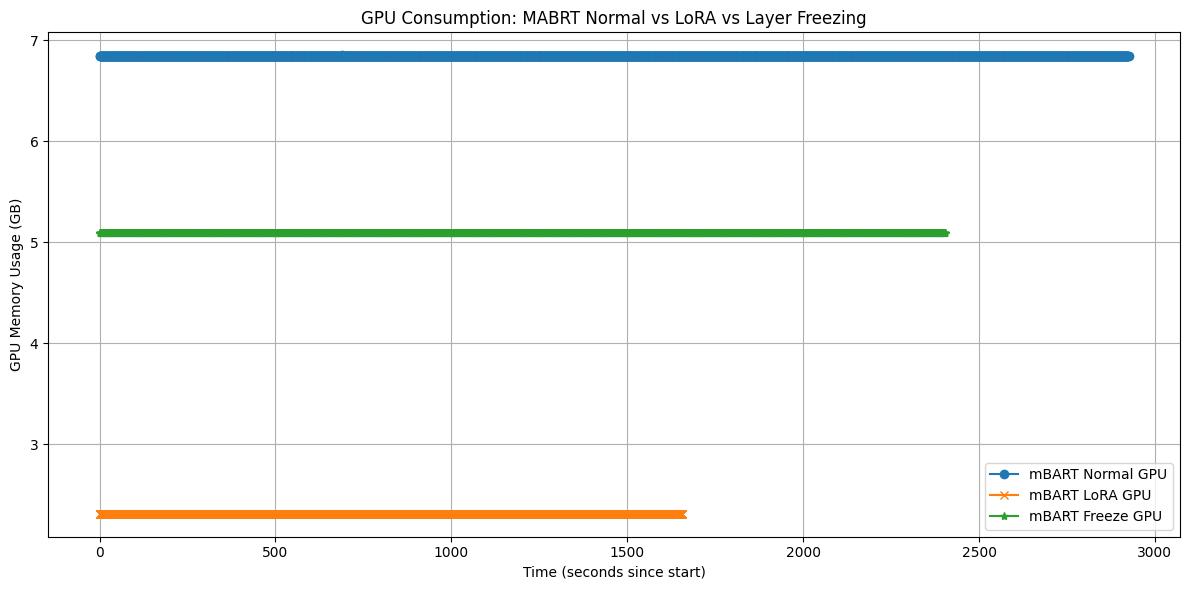

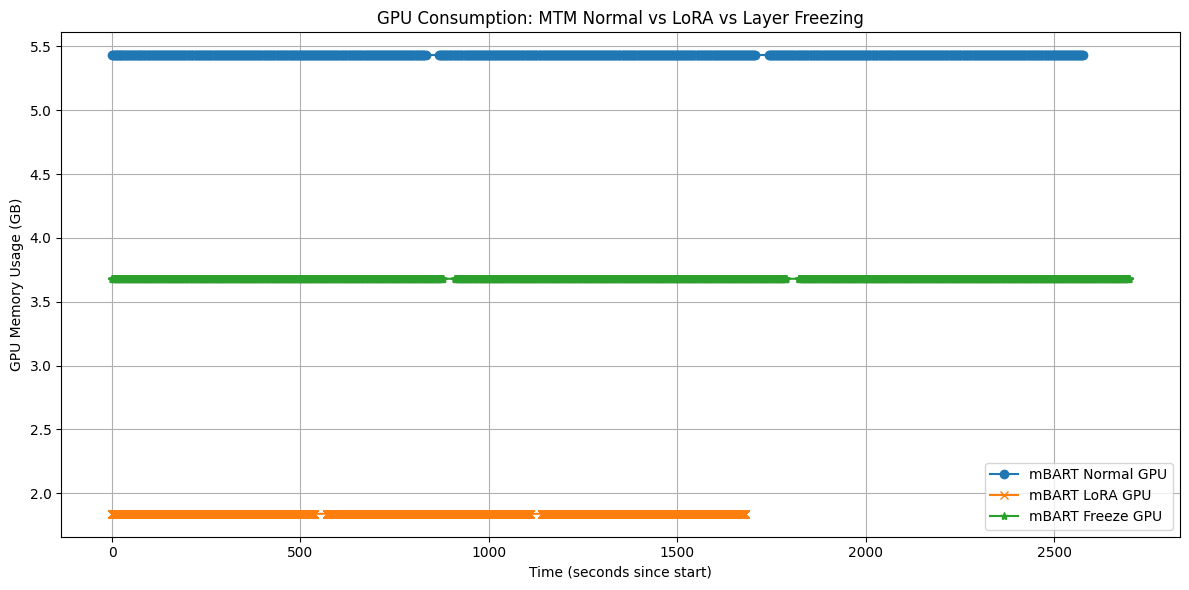

In [ ]:
# # Plot for mBart
plot_memory_usage("/content/drive/MyDrive/CIS5800/Log/mBART/Education/memory_usage.log",
                  "/content/drive/MyDrive/CIS5800/Log/mBART/Education/memory_usage_lora.log",
                  "/content/drive/MyDrive/CIS5800/Log/mBART/Education/memory_usage_freeze.log",
                  "mabrt")

# Plot for m2m
plot_memory_usage("/content/drive/MyDrive/CIS5800/Log/m2m/Education/memory_usage.log",
                  "/content/drive/MyDrive/CIS5800/Log/m2m/Education/memory_usage_lora.log",
                  "/content/drive/MyDrive/CIS5800/Log/m2m/Education/memory_usage_freeze.log",
                  "mtm")

## **7. Extra Exploration: Quantized General-Purpose LLMs and Language-Specific Models**


### **7.1 Pre-Quantized Llamma**

In [ ]:
model_name_or_path = "TheBloke/Chinese-Alpaca-2-7B-GPTQ"

Alpaca = AutoModelForCausalLM.from_pretrained(model_name_or_path,
                                             device_map="auto",
                                             trust_remote_code=False,
                                             revision="main")

Alpaca_tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)

prompt = "我爱机器学习"
prompt_template=f'''Below is a Chinese sentence. Translate it into English.

### Instruction:
{prompt}

### Response:

'''

print("\n\n*** Generate:")

input_ids = Alpaca_tokenizer(prompt_template, return_tensors='pt').input_ids.cuda()
output = Alpaca.generate(inputs=input_ids, temperature=0.7, do_sample=True, top_p=0.95, top_k=40, max_new_tokens=512)
print(Alpaca_tokenizer.decode(output[0]).replace('</s>', ''))

Some weights of the model checkpoint at TheBloke/Chinese-Alpaca-2-7B-GPTQ were not used when initializing LlamaForCausalLM: ['model.layers.0.mlp.down_proj.bias', 'model.layers.0.mlp.gate_proj.bias', 'model.layers.0.mlp.up_proj.bias', 'model.layers.0.self_attn.k_proj.bias', 'model.layers.0.self_attn.o_proj.bias', 'model.layers.0.self_attn.q_proj.bias', 'model.layers.0.self_attn.v_proj.bias', 'model.layers.1.mlp.down_proj.bias', 'model.layers.1.mlp.gate_proj.bias', 'model.layers.1.mlp.up_proj.bias', 'model.layers.1.self_attn.k_proj.bias', 'model.layers.1.self_attn.o_proj.bias', 'model.layers.1.self_attn.q_proj.bias', 'model.layers.1.self_attn.v_proj.bias', 'model.layers.10.mlp.down_proj.bias', 'model.layers.10.mlp.gate_proj.bias', 'model.layers.10.mlp.up_proj.bias', 'model.layers.10.self_attn.k_proj.bias', 'model.layers.10.self_attn.o_proj.bias', 'model.layers.10.self_attn.q_proj.bias', 'model.layers.10.self_attn.v_proj.bias', 'model.layers.11.mlp.down_proj.bias', 'model.layers.11.mlp.ga



*** Generate:
<s> Below is a Chinese sentence. Translate it into English.

### Instruction:
我爱机器学习

### Response:

I love machine learning.


In [ ]:
train_data, dev_data, test_data = load_data_from_txt(data_file_path, sample_size = 50000)

In [ ]:
from transformers import AutoModelForCausalLM

# Define the model name or path
model_name_or_path = "TheBloke/Chinese-Alpaca-2-7B-GPTQ"

# Load the model
model = AutoModelForCausalLM.from_pretrained(
    model_name_or_path,
    device_map="auto",             # Automatically map layers to available devices
    trust_remote_code=True         # Enable remote code if required
)

# Calculate the number of trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {trainable_params}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/924 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.28G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:5055: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
Some weights of the model checkpoint at TheBloke/Chinese-Alpaca-2-7B-GPTQ were not used when initializing LlamaForCausalLM: ['model.layers.0.mlp.down_proj.bias', 'model.layers.0.mlp.gate_proj.bias', 'model.layers.0.mlp.up_proj.bias', 'model.layers.0.self_attn.k_proj.bias', 'model.layers.0.self_attn.o_proj.bias', 'model.layers.0.self_attn.q_proj.bias', 'model.layers.0.self_attn.v_proj.bias', 'model.layers.1.mlp.down_proj.bias', 'model.layers.1.mlp.gate_proj.bias', 'model.layers.1.mlp.up_proj.bias', 'model.layers.1.self_attn.k_proj.bias', 'model.layers.1.self_attn.o_proj.bias', 'model.layers.1.self_attn.q_proj.bias', 'model.layers.1.self_attn.v

generation_config.json:   0%|          | 0.00/131 [00:00<?, ?B/s]

Number of trainable parameters: 453251072


In [ ]:
evaluate_bleu_score(Alpaca, Alpaca_tokenizer, test_data, max_length=200, device="cuda", Alpaca = True)

Calculating BLEU Scores: 100%|██████████| 5000/5000 [10:06:58<00:00,  7.28s/it]

Average BLEU score for the test set: 0.0511


0.051076716055391054

### **7.2 MarianMT - Chinese to English Only**

In [ ]:
model_id = "Helsinki-NLP/opus-mt-zh-en"

quantization_config = BitsAndBytesConfig(load_in_8bit=True)

MarianMT_tokenizer = AutoTokenizer.from_pretrained(model_id)
MarianMT_model = AutoModelForSeq2SeqLM.from_pretrained(
    model_id,
    quantization_config=quantization_config,
    low_cpu_mem_usage=True
)

input_text = "我爱机器学习，我爱自然语言处理"
inputs = MarianMT_tokenizer(input_text, return_tensors="pt").to("cuda")
outputs = MarianMT_model.generate(**inputs, max_length=50)

translated_text = MarianMT_tokenizer.decode(outputs[0], skip_special_tokens=True)
print(translated_text)

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


model.safetensors:   0%|          | 0.00/312M [00:00<?, ?B/s]

I love machine learning. I love natural language.


**Trainable Parameters for Self-Quantized Mariana MT**

In [ ]:
from transformers import AutoModel

# Load the model
model_name = "Helsinki-NLP/opus-mt-zh-en"
model = AutoModel.from_pretrained(model_name)

# Count the number of trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 77419008


In [ ]:
train_data, dev_data, test_data = load_data_from_txt(data_file_path, sample_size = 50000)

Loaded train data with 40000 samples.
Loaded dev data with 5000 samples.
Loaded test data with 5000 samples.


In [ ]:
evaluate_bleu_score(MarianMT_model, MarianMT_tokenizer, test_data, max_length=200, device="cuda", Alpaca = False)

Calculating BLEU Scores: 100%|██████████| 5000/5000 [1:20:03<00:00,  1.04it/s]

Average BLEU score for the test set: 0.1029


0.10293217807613292